In [1]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace


In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_fix_stats_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:

configs.data_name = data_name



In [7]:

pp = "mm-spec" 

if pp == "mm-spec":
    specifier = specifier + "--pp: " + pp

    
    
configs.specifier = specifier



In [8]:

configs.specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

## Load Data

In [84]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [10]:
data_name

'dd_fix_stats_demo'

In [11]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]

elif data_name == "dd_fix_stats_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    fix_stats = dd.get_fix_stats_dataset()  # fixes

    # concatenate pd.dfs to a pd.df
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix_stats = fix_stats.loc[fix_stats.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_stats_demo = dd.concat_dfs(
        df1=fix_stats,
        df2=demo_phono,
        features1=fix_stats.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_stats_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID',
    ]

    targets = ["Group", "Reading_speed", ]

    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report statistics data: (9071, 10)


In [85]:
fixes = dd.get_fix_datasets()  # fixes



Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 


In [89]:
fix_norm = fixes['norm']

fix_norm

,Group,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
0,1,10,4,1,177.3,531.8,219.0
1,1,10,4,2,200.5,545.2,247.0
2,1,10,4,3,282.7,542.4,261.0
3,1,10,4,4,358.1,545.5,268.0
4,1,10,4,4,392.8,536.3,129.0
...,...,...,...,...,...,...,...
139502,1,varya_norm1,33,5,739.0,529.9,563.0
139503,1,varya_norm1,33,5,776.6,531.6,149.0
139504,1,varya_norm1,33,5,830.3,536.0,252.0
139505,1,varya_norm1,33,5,896.8,541.6,152.0


In [12]:


data_name



'dd_fix_stats_demo'

In [13]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,8,645.693750,283.247212,537.731250,5.683393,147.500000,78.438086,1,4,10,23,102.0
1,1,10,5,8,644.781081,202.020928,524.345946,8.486152,180.810811,88.588574,1,4,10,23,102.0
2,1,10,6,9,708.334615,292.435973,536.546154,7.099140,187.961538,130.054290,1,4,10,23,102.0
3,1,10,7,8,676.047619,317.074279,535.933333,6.465627,179.761905,73.502996,1,4,10,23,102.0
4,1,10,8,8,440.215000,235.935556,541.580000,5.290667,201.800000,91.100638,1,4,10,23,102.0


In [14]:
df_data_to_use.shape

(9071, 15)

In [15]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [16]:

x_org.head()



,FIX_Y_mean,Age,Grade_6,Grade_1,Sex_1,FIX_DURATION_mean,FIX_Y_std,Sex_2,Grade_4,IQ,Grade_2,FIX_DURATION_std,Grade_5,FIX_X_mean,Word_Number,Grade_3,FIX_X_std
0,537.731250,10,0,0,1,147.500000,5.683393,0,1,23,0,78.438086,0,645.693750,8,0,283.247212
1,524.345946,10,0,0,1,180.810811,8.486152,0,1,23,0,88.588574,0,644.781081,8,0,202.020928
2,536.546154,10,0,0,1,187.961538,7.099140,0,1,23,0,130.054290,0,708.334615,9,0,292.435973
3,535.933333,10,0,0,1,179.761905,6.465627,0,1,23,0,73.502996,0,676.047619,8,0,317.074279
4,541.580000,10,0,0,1,201.800000,5.290667,0,1,23,0,91.100638,0,440.215000,8,0,235.935556


In [17]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [18]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [19]:

# x = preprocess_data(x=x_org, pp="mm")  # only x is standardized


# x_df = dd.get_preprocessed_train_test_onehot_features(x_dum=x_org)
# x = x_df.values

x = preprocess_data(x=x_org, pp='mm')  # only x is standardized



pre-processing: mm
Preprocessed data shape: (9071, 17)


In [20]:

# data = dd.get_stratified_train_test_splits(
#         x=x, y=y,
#         labels=y_org.Group.values,
#         to_shuffle=to_shuffle,
#         n_splits=10
#     )



# for k, v in data.items():
#     print(k, v['x_train'].shape, v['x_test'].shape,)
    
    

## Load the tuned parameters

In [21]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 27),
             ('max_iter', 34339),
             ('solver', 'lbfgs')])

In [22]:


specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

In [23]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl




MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [25]:

# n_s = str(6)
# x_train = data[n_s]["x_train"]
# x_test = data[n_s]["x_test"]
# y_train = data[n_s]["y_train"]
# y_test = data[n_s]["y_test"]


# Using the entire set to train the model, cause we have independent test
idx = np.random.permutation(len(x))

x_train = x[idx, :]
y_train = y[idx]



In [26]:


class_names = ['Norm', 'At-risk', 'Dyslexic']



## Previously obtained results

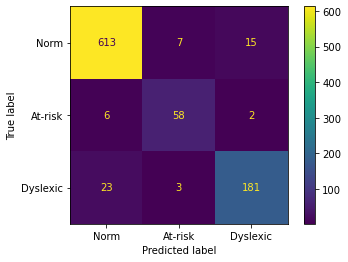

Kappa: 0.8630615102876226 AUC ROC: 0.9834043640479089


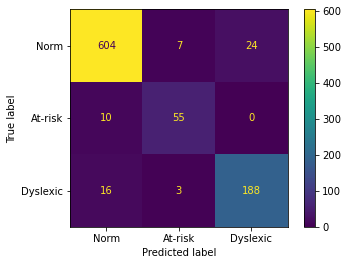

Kappa: 0.8546823680205079 AUC ROC: 0.9807125339457422


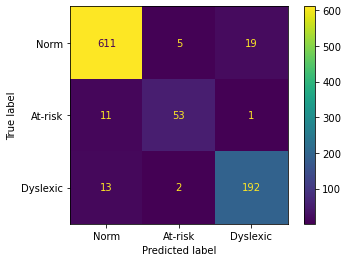

Kappa: 0.8755327736519212 AUC ROC: 0.987638420965078


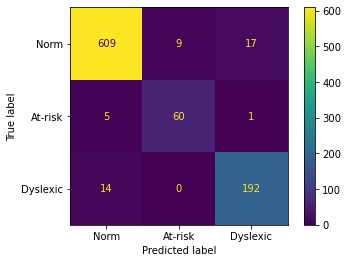

Kappa: 0.8890534629243063 AUC ROC: 0.9863454615183456


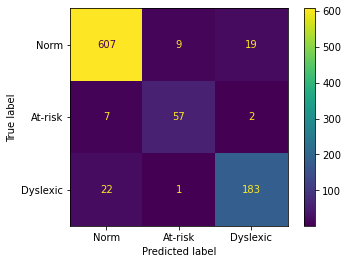

Kappa: 0.8538444391327351 AUC ROC: 0.9823381894225923


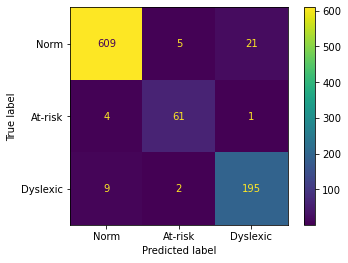

Kappa: 0.8993524250374516 AUC ROC: 0.9893629685916602


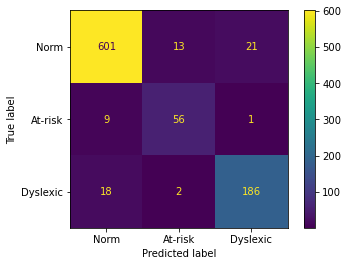

Kappa: 0.8457544475002325 AUC ROC: 0.9825137054319666


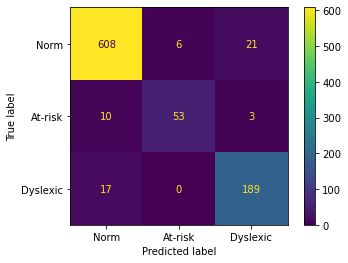

Kappa: 0.8608940621872074 AUC ROC: 0.98330948555894


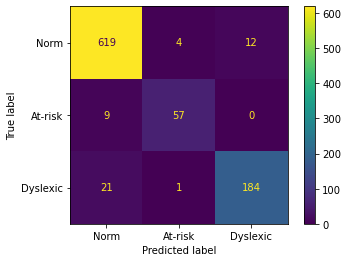

Kappa: 0.8835483218873099 AUC ROC: 0.9884392730119028


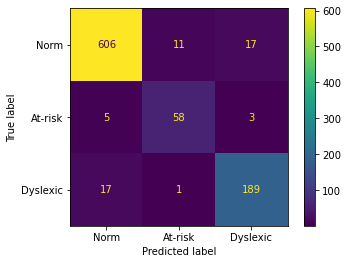

Kappa: 0.869951727763705 AUC ROC: 0.9871912801585697


In [27]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )



for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [28]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.806 0.022 0.690 0.031 0.941 0.007 0.941 0.007 0.941 0.007 0.985 0.003 1.064 0.126 0.088 0.005 0.941 0.007 0.929 0.013


In [29]:


mdl.fit(x_train, y_train)



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          570     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06096D+00    |proj g|=  3.43197D-01

At iterate    1    f=  7.98880D-01    |proj g|=  3.70889D-02

At iterate    2    f=  7.90394D-01    |proj g|=  3.38859D-02

At iterate    3    f=  7.58741D-01    |proj g|=  2.95447D-02

At iterate    4    f=  7.44015D-01    |proj g|=  1.84588D-02

At iterate    5    f=  7.26736D-01    |proj g|=  1.57235D-02

At iterate    6    f=  7.12040D-01    |proj g|=  1.68778D-02

At iterate    7    f=  6.95340D-01    |proj g|=  1.43514D-02

At iterate    8    f=  6.80260D-01    |proj g|=  2.99970D-02

At iterate    9    f=  6.65860D-01    |proj g|=  5.11331D-02

At iterate   10    f=  6.45862D-01    |proj g|=  2.07064D-02

At iterate   11    f=  6.39241D-01    |proj g|=  1.67149D-02

At iterate   12    f=  6.32921D-01    |proj g|=  6.46477D-02

At iterate   13    f=  6.2


At iterate  133    f=  4.25354D-01    |proj g|=  7.10650D-03

At iterate  134    f=  4.25145D-01    |proj g|=  6.11710D-03

At iterate  135    f=  4.24213D-01    |proj g|=  4.71962D-03

At iterate  136    f=  4.23061D-01    |proj g|=  4.63907D-03

At iterate  137    f=  4.22194D-01    |proj g|=  1.25825D-02

At iterate  138    f=  4.20897D-01    |proj g|=  7.32491D-03

At iterate  139    f=  4.20146D-01    |proj g|=  5.37806D-03

At iterate  140    f=  4.19653D-01    |proj g|=  6.68622D-03

At iterate  141    f=  4.19000D-01    |proj g|=  6.70045D-03

At iterate  142    f=  4.17687D-01    |proj g|=  8.53648D-03

At iterate  143    f=  4.15855D-01    |proj g|=  1.15601D-02

At iterate  144    f=  4.14761D-01    |proj g|=  1.25960D-02

At iterate  145    f=  4.13556D-01    |proj g|=  1.06255D-02

At iterate  146    f=  4.12577D-01    |proj g|=  1.45266D-02

At iterate  147    f=  4.11786D-01    |proj g|=  9.24230D-03

At iterate  148    f=  4.09767D-01    |proj g|=  9.28283D-03

At iter


At iterate  276    f=  3.20629D-01    |proj g|=  4.06596D-03

At iterate  277    f=  3.20111D-01    |proj g|=  3.96749D-03

At iterate  278    f=  3.19323D-01    |proj g|=  5.89049D-03

At iterate  279    f=  3.18795D-01    |proj g|=  1.19716D-02

At iterate  280    f=  3.18091D-01    |proj g|=  5.45043D-03

At iterate  281    f=  3.17389D-01    |proj g|=  3.85396D-03

At iterate  282    f=  3.17014D-01    |proj g|=  8.63205D-03

At iterate  283    f=  3.16870D-01    |proj g|=  1.15668D-02

At iterate  284    f=  3.16540D-01    |proj g|=  3.54679D-03

At iterate  285    f=  3.16338D-01    |proj g|=  3.22553D-03

At iterate  286    f=  3.16099D-01    |proj g|=  4.80835D-03

At iterate  287    f=  3.15648D-01    |proj g|=  6.42006D-03

At iterate  288    f=  3.15209D-01    |proj g|=  1.42056D-02

At iterate  289    f=  3.14264D-01    |proj g|=  5.90500D-03

At iterate  290    f=  3.13378D-01    |proj g|=  5.86352D-03

At iterate  291    f=  3.12488D-01    |proj g|=  6.13188D-03

At iter


At iterate  413    f=  2.49728D-01    |proj g|=  5.63540D-03

At iterate  414    f=  2.49461D-01    |proj g|=  3.68930D-03

At iterate  415    f=  2.49256D-01    |proj g|=  2.75862D-03

At iterate  416    f=  2.48761D-01    |proj g|=  4.53331D-03

At iterate  417    f=  2.48266D-01    |proj g|=  3.85033D-03

At iterate  418    f=  2.48089D-01    |proj g|=  5.96100D-03

At iterate  419    f=  2.47794D-01    |proj g|=  3.91648D-03

At iterate  420    f=  2.47628D-01    |proj g|=  4.22103D-03

At iterate  421    f=  2.47499D-01    |proj g|=  1.03776D-02

At iterate  422    f=  2.47279D-01    |proj g|=  5.27037D-03

At iterate  423    f=  2.46894D-01    |proj g|=  4.28871D-03

At iterate  424    f=  2.46684D-01    |proj g|=  5.49098D-03

At iterate  425    f=  2.46124D-01    |proj g|=  5.11246D-03

At iterate  426    f=  2.45874D-01    |proj g|=  9.21479D-03

At iterate  427    f=  2.45338D-01    |proj g|=  5.35628D-03

At iterate  428    f=  2.44961D-01    |proj g|=  3.95410D-03

At iter


At iterate  567    f=  1.99139D-01    |proj g|=  4.63890D-03

At iterate  568    f=  1.98960D-01    |proj g|=  4.06859D-03

At iterate  569    f=  1.98580D-01    |proj g|=  2.62961D-03

At iterate  570    f=  1.98336D-01    |proj g|=  3.72297D-03

At iterate  571    f=  1.98056D-01    |proj g|=  2.95531D-03

At iterate  572    f=  1.97731D-01    |proj g|=  2.66698D-03

At iterate  573    f=  1.97215D-01    |proj g|=  6.02379D-03

At iterate  574    f=  1.96801D-01    |proj g|=  4.42686D-03

At iterate  575    f=  1.96505D-01    |proj g|=  2.69193D-03

At iterate  576    f=  1.96214D-01    |proj g|=  4.45181D-03

At iterate  577    f=  1.96009D-01    |proj g|=  4.68080D-03

At iterate  578    f=  1.95854D-01    |proj g|=  3.50455D-03

At iterate  579    f=  1.95667D-01    |proj g|=  6.95626D-03

At iterate  580    f=  1.95526D-01    |proj g|=  3.34998D-03

At iterate  581    f=  1.95451D-01    |proj g|=  3.34276D-03

At iterate  582    f=  1.95181D-01    |proj g|=  4.23877D-03

At iter


At iterate  715    f=  1.74115D-01    |proj g|=  2.11358D-03

At iterate  716    f=  1.73935D-01    |proj g|=  3.02354D-03

At iterate  717    f=  1.73801D-01    |proj g|=  3.68662D-03

At iterate  718    f=  1.73674D-01    |proj g|=  2.04451D-03

At iterate  719    f=  1.73545D-01    |proj g|=  2.87234D-03

At iterate  720    f=  1.73395D-01    |proj g|=  6.51940D-03

At iterate  721    f=  1.73253D-01    |proj g|=  3.88048D-03

At iterate  722    f=  1.73142D-01    |proj g|=  5.48139D-03

At iterate  723    f=  1.73099D-01    |proj g|=  6.81664D-03

At iterate  724    f=  1.73029D-01    |proj g|=  2.12912D-03

At iterate  725    f=  1.72991D-01    |proj g|=  1.96695D-03

At iterate  726    f=  1.72886D-01    |proj g|=  4.01622D-03

At iterate  727    f=  1.72754D-01    |proj g|=  4.98469D-03

At iterate  728    f=  1.72539D-01    |proj g|=  8.29433D-03

At iterate  729    f=  1.72386D-01    |proj g|=  6.44301D-03

At iterate  730    f=  1.72212D-01    |proj g|=  2.04718D-03

At iter


At iterate  863    f=  1.57944D-01    |proj g|=  2.76622D-03

At iterate  864    f=  1.57899D-01    |proj g|=  1.61360D-03

At iterate  865    f=  1.57835D-01    |proj g|=  2.42164D-03

At iterate  866    f=  1.57754D-01    |proj g|=  6.61028D-03

At iterate  867    f=  1.57653D-01    |proj g|=  3.95608D-03

At iterate  868    f=  1.57570D-01    |proj g|=  2.06480D-03

At iterate  869    f=  1.57498D-01    |proj g|=  2.94096D-03

At iterate  870    f=  1.57449D-01    |proj g|=  2.60683D-03

At iterate  871    f=  1.57386D-01    |proj g|=  2.45712D-03

At iterate  872    f=  1.57173D-01    |proj g|=  1.96809D-03

At iterate  873    f=  1.57155D-01    |proj g|=  8.21592D-03

At iterate  874    f=  1.56995D-01    |proj g|=  2.16876D-03

At iterate  875    f=  1.56937D-01    |proj g|=  2.22089D-03

At iterate  876    f=  1.56854D-01    |proj g|=  2.10358D-03

At iterate  877    f=  1.56734D-01    |proj g|=  2.98195D-03

At iterate  878    f=  1.56688D-01    |proj g|=  6.06910D-03

At iter


At iterate 1019    f=  1.47296D-01    |proj g|=  7.92559D-03

At iterate 1020    f=  1.47218D-01    |proj g|=  2.34214D-03

At iterate 1021    f=  1.47160D-01    |proj g|=  2.75459D-03

At iterate 1022    f=  1.47070D-01    |proj g|=  2.09071D-03

At iterate 1023    f=  1.46988D-01    |proj g|=  4.63240D-03

At iterate 1024    f=  1.46919D-01    |proj g|=  1.82217D-03

At iterate 1025    f=  1.46883D-01    |proj g|=  1.72810D-03

At iterate 1026    f=  1.46827D-01    |proj g|=  2.12539D-03

At iterate 1027    f=  1.46758D-01    |proj g|=  2.83955D-03

At iterate 1028    f=  1.46696D-01    |proj g|=  6.50428D-03

At iterate 1029    f=  1.46621D-01    |proj g|=  2.46426D-03

At iterate 1030    f=  1.46586D-01    |proj g|=  1.84031D-03

At iterate 1031    f=  1.46550D-01    |proj g|=  6.62682D-03

At iterate 1032    f=  1.46509D-01    |proj g|=  1.68158D-03

At iterate 1033    f=  1.46475D-01    |proj g|=  1.67447D-03

At iterate 1034    f=  1.46422D-01    |proj g|=  1.78848D-03

At iter


At iterate 1158    f=  1.40294D-01    |proj g|=  3.11509D-03

At iterate 1159    f=  1.40268D-01    |proj g|=  1.53791D-03

At iterate 1160    f=  1.40216D-01    |proj g|=  1.41149D-03

At iterate 1161    f=  1.40164D-01    |proj g|=  2.14446D-03

At iterate 1162    f=  1.40063D-01    |proj g|=  5.30405D-03

At iterate 1163    f=  1.39989D-01    |proj g|=  5.44401D-03

At iterate 1164    f=  1.39938D-01    |proj g|=  2.74190D-03

At iterate 1165    f=  1.39873D-01    |proj g|=  1.44149D-03

At iterate 1166    f=  1.39821D-01    |proj g|=  1.95810D-03

At iterate 1167    f=  1.39756D-01    |proj g|=  7.76939D-03

At iterate 1168    f=  1.39684D-01    |proj g|=  2.11406D-03

At iterate 1169    f=  1.39644D-01    |proj g|=  1.79933D-03

At iterate 1170    f=  1.39611D-01    |proj g|=  5.30388D-03

At iterate 1171    f=  1.39571D-01    |proj g|=  3.42316D-03

At iterate 1172    f=  1.39542D-01    |proj g|=  1.84480D-03

At iterate 1173    f=  1.39507D-01    |proj g|=  1.92678D-03

At iter


At iterate 1298    f=  1.33750D-01    |proj g|=  2.94557D-03

At iterate 1299    f=  1.33713D-01    |proj g|=  2.12612D-03

At iterate 1300    f=  1.33677D-01    |proj g|=  3.22885D-03

At iterate 1301    f=  1.33635D-01    |proj g|=  4.32316D-03

At iterate 1302    f=  1.33594D-01    |proj g|=  2.77822D-03

At iterate 1303    f=  1.33562D-01    |proj g|=  1.70450D-03

At iterate 1304    f=  1.33521D-01    |proj g|=  2.66683D-03

At iterate 1305    f=  1.33488D-01    |proj g|=  2.80814D-03

At iterate 1306    f=  1.33414D-01    |proj g|=  4.09017D-03

At iterate 1307    f=  1.33360D-01    |proj g|=  2.85060D-03

At iterate 1308    f=  1.33328D-01    |proj g|=  1.50696D-03

At iterate 1309    f=  1.33291D-01    |proj g|=  1.60156D-03

At iterate 1310    f=  1.33245D-01    |proj g|=  2.45648D-03

At iterate 1311    f=  1.33173D-01    |proj g|=  2.74906D-03

At iterate 1312    f=  1.33132D-01    |proj g|=  7.66192D-03

At iterate 1313    f=  1.33067D-01    |proj g|=  4.34606D-03

At iter


At iterate 1438    f=  1.28747D-01    |proj g|=  3.96087D-03

At iterate 1439    f=  1.28703D-01    |proj g|=  1.77831D-03

At iterate 1440    f=  1.28677D-01    |proj g|=  1.50757D-03

At iterate 1441    f=  1.28673D-01    |proj g|=  5.12633D-03

At iterate 1442    f=  1.28645D-01    |proj g|=  1.48350D-03

At iterate 1443    f=  1.28637D-01    |proj g|=  1.21255D-03

At iterate 1444    f=  1.28622D-01    |proj g|=  1.50201D-03

At iterate 1445    f=  1.28600D-01    |proj g|=  1.94335D-03

At iterate 1446    f=  1.28554D-01    |proj g|=  4.49310D-03

At iterate 1447    f=  1.28506D-01    |proj g|=  2.79530D-03

At iterate 1448    f=  1.28480D-01    |proj g|=  1.13412D-03

At iterate 1449    f=  1.28458D-01    |proj g|=  1.66834D-03

At iterate 1450    f=  1.28440D-01    |proj g|=  1.92712D-03

At iterate 1451    f=  1.28394D-01    |proj g|=  3.13020D-03

At iterate 1452    f=  1.28373D-01    |proj g|=  3.99252D-03

At iterate 1453    f=  1.28340D-01    |proj g|=  1.74897D-03

At iter


At iterate 1576    f=  1.24837D-01    |proj g|=  2.57722D-03

At iterate 1577    f=  1.24805D-01    |proj g|=  2.48710D-03

At iterate 1578    f=  1.24777D-01    |proj g|=  3.40240D-03

At iterate 1579    f=  1.24750D-01    |proj g|=  2.56020D-03

At iterate 1580    f=  1.24707D-01    |proj g|=  4.71086D-03

At iterate 1581    f=  1.24664D-01    |proj g|=  1.93776D-03

At iterate 1582    f=  1.24647D-01    |proj g|=  2.25802D-03

At iterate 1583    f=  1.24632D-01    |proj g|=  2.90533D-03

At iterate 1584    f=  1.24612D-01    |proj g|=  1.84840D-03

At iterate 1585    f=  1.24594D-01    |proj g|=  2.39372D-03

At iterate 1586    f=  1.24556D-01    |proj g|=  1.77556D-03

At iterate 1587    f=  1.24521D-01    |proj g|=  1.77099D-03

At iterate 1588    f=  1.24492D-01    |proj g|=  5.94640D-03

At iterate 1589    f=  1.24437D-01    |proj g|=  1.57116D-03

At iterate 1590    f=  1.24414D-01    |proj g|=  2.56991D-03

At iterate 1591    f=  1.24367D-01    |proj g|=  2.07964D-03

At iter


At iterate 1730    f=  1.19343D-01    |proj g|=  1.85331D-03

At iterate 1731    f=  1.19291D-01    |proj g|=  2.05379D-03

At iterate 1732    f=  1.19269D-01    |proj g|=  4.83625D-03

At iterate 1733    f=  1.19237D-01    |proj g|=  1.61845D-03

At iterate 1734    f=  1.19204D-01    |proj g|=  2.21655D-03

At iterate 1735    f=  1.19177D-01    |proj g|=  4.18023D-03

At iterate 1736    f=  1.19143D-01    |proj g|=  3.57608D-03

At iterate 1737    f=  1.19119D-01    |proj g|=  1.62395D-03

At iterate 1738    f=  1.19100D-01    |proj g|=  1.68344D-03

At iterate 1739    f=  1.19070D-01    |proj g|=  2.16642D-03

At iterate 1740    f=  1.19021D-01    |proj g|=  2.43245D-03

At iterate 1741    f=  1.18998D-01    |proj g|=  5.22398D-03

At iterate 1742    f=  1.18950D-01    |proj g|=  1.76461D-03

At iterate 1743    f=  1.18923D-01    |proj g|=  2.54221D-03

At iterate 1744    f=  1.18891D-01    |proj g|=  3.06641D-03

At iterate 1745    f=  1.18844D-01    |proj g|=  4.86266D-03

At iter


At iterate 1865    f=  1.14125D-01    |proj g|=  3.86968D-03

At iterate 1866    f=  1.14096D-01    |proj g|=  2.19128D-03

At iterate 1867    f=  1.14057D-01    |proj g|=  3.54148D-03

At iterate 1868    f=  1.14017D-01    |proj g|=  4.79048D-03

At iterate 1869    f=  1.13957D-01    |proj g|=  5.69559D-03

At iterate 1870    f=  1.13916D-01    |proj g|=  6.35644D-03

At iterate 1871    f=  1.13869D-01    |proj g|=  4.17436D-03

At iterate 1872    f=  1.13811D-01    |proj g|=  5.08146D-03

At iterate 1873    f=  1.13759D-01    |proj g|=  7.18207D-03

At iterate 1874    f=  1.13721D-01    |proj g|=  6.39905D-03

At iterate 1875    f=  1.13665D-01    |proj g|=  2.70793D-03

At iterate 1876    f=  1.13634D-01    |proj g|=  1.85072D-03

At iterate 1877    f=  1.13583D-01    |proj g|=  4.48273D-03

At iterate 1878    f=  1.13543D-01    |proj g|=  5.71838D-03

At iterate 1879    f=  1.13511D-01    |proj g|=  2.41165D-03

At iterate 1880    f=  1.13470D-01    |proj g|=  2.24655D-03

At iter

At iterate 2004    f=  1.09381D-01    |proj g|=  2.25209D-03

At iterate 2005    f=  1.09362D-01    |proj g|=  3.48153D-03

At iterate 2006    f=  1.09339D-01    |proj g|=  3.74392D-03

At iterate 2007    f=  1.09284D-01    |proj g|=  3.93011D-03

At iterate 2008    f=  1.09262D-01    |proj g|=  3.65369D-03

At iterate 2009    f=  1.09223D-01    |proj g|=  1.99285D-03

At iterate 2010    f=  1.09195D-01    |proj g|=  1.74235D-03

At iterate 2011    f=  1.09161D-01    |proj g|=  6.66511D-03

At iterate 2012    f=  1.09120D-01    |proj g|=  2.78015D-03

At iterate 2013    f=  1.09095D-01    |proj g|=  2.15249D-03

At iterate 2014    f=  1.09053D-01    |proj g|=  2.91122D-03

At iterate 2015    f=  1.09028D-01    |proj g|=  2.94742D-03

At iterate 2016    f=  1.08998D-01    |proj g|=  3.85152D-03

At iterate 2017    f=  1.08972D-01    |proj g|=  2.31692D-03

At iterate 2018    f=  1.08950D-01    |proj g|=  1.68771D-03

At iterate 2019    f=  1.08916D-01    |proj g|=  5.03943D-03

At itera

At iterate 2142    f=  1.05359D-01    |proj g|=  2.40968D-03

At iterate 2143    f=  1.05341D-01    |proj g|=  1.94693D-03

At iterate 2144    f=  1.05319D-01    |proj g|=  3.01350D-03

At iterate 2145    f=  1.05289D-01    |proj g|=  2.79746D-03

At iterate 2146    f=  1.05283D-01    |proj g|=  1.02355D-02

At iterate 2147    f=  1.05233D-01    |proj g|=  3.56181D-03

At iterate 2148    f=  1.05220D-01    |proj g|=  1.40967D-03

At iterate 2149    f=  1.05209D-01    |proj g|=  1.85200D-03

At iterate 2150    f=  1.05188D-01    |proj g|=  3.18027D-03

At iterate 2151    f=  1.05152D-01    |proj g|=  1.76425D-03

At iterate 2152    f=  1.05120D-01    |proj g|=  1.97284D-03

At iterate 2153    f=  1.05092D-01    |proj g|=  4.14056D-03

At iterate 2154    f=  1.05079D-01    |proj g|=  3.43728D-03

At iterate 2155    f=  1.05069D-01    |proj g|=  1.39347D-03

At iterate 2156    f=  1.05059D-01    |proj g|=  1.15117D-03

At iterate 2157    f=  1.05038D-01    |proj g|=  2.82525D-03

At itera

At iterate 2286    f=  1.02440D-01    |proj g|=  3.74406D-03

At iterate 2287    f=  1.02412D-01    |proj g|=  1.77730D-03

At iterate 2288    f=  1.02391D-01    |proj g|=  1.64366D-03

At iterate 2289    f=  1.02361D-01    |proj g|=  1.87146D-03

At iterate 2290    f=  1.02296D-01    |proj g|=  6.44845D-03

At iterate 2291    f=  1.02263D-01    |proj g|=  4.56499D-03

At iterate 2292    f=  1.02236D-01    |proj g|=  1.95319D-03

At iterate 2293    f=  1.02217D-01    |proj g|=  2.02314D-03

At iterate 2294    f=  1.02204D-01    |proj g|=  6.80343D-03

At iterate 2295    f=  1.02182D-01    |proj g|=  2.80598D-03

At iterate 2296    f=  1.02158D-01    |proj g|=  2.01852D-03

At iterate 2297    f=  1.02150D-01    |proj g|=  1.71373D-03

At iterate 2298    f=  1.02133D-01    |proj g|=  3.17320D-03

At iterate 2299    f=  1.02118D-01    |proj g|=  4.43776D-03

At iterate 2300    f=  1.02098D-01    |proj g|=  1.73402D-03

At iterate 2301    f=  1.02085D-01    |proj g|=  1.38527D-03

At itera


At iterate 2436    f=  1.00068D-01    |proj g|=  2.55241D-03

At iterate 2437    f=  1.00054D-01    |proj g|=  1.85869D-03

At iterate 2438    f=  1.00044D-01    |proj g|=  3.01916D-03

At iterate 2439    f=  1.00032D-01    |proj g|=  1.71342D-03

At iterate 2440    f=  1.00019D-01    |proj g|=  1.28359D-03

At iterate 2441    f=  1.00012D-01    |proj g|=  4.55458D-03

At iterate 2442    f=  9.99933D-02    |proj g|=  1.39976D-03

At iterate 2443    f=  9.99854D-02    |proj g|=  1.14108D-03

At iterate 2444    f=  9.99760D-02    |proj g|=  1.89777D-03

At iterate 2445    f=  9.99716D-02    |proj g|=  5.01524D-03

At iterate 2446    f=  9.99591D-02    |proj g|=  1.77622D-03

At iterate 2447    f=  9.99524D-02    |proj g|=  1.28477D-03

At iterate 2448    f=  9.99451D-02    |proj g|=  1.38084D-03

At iterate 2449    f=  9.99334D-02    |proj g|=  1.93297D-03

At iterate 2450    f=  9.99262D-02    |proj g|=  5.58254D-03

At iterate 2451    f=  9.99030D-02    |proj g|=  1.80414D-03

At iter


At iterate 2582    f=  9.87216D-02    |proj g|=  3.12997D-03

At iterate 2583    f=  9.87084D-02    |proj g|=  1.65600D-03

At iterate 2584    f=  9.86979D-02    |proj g|=  1.81285D-03

At iterate 2585    f=  9.86946D-02    |proj g|=  8.34834D-03

At iterate 2586    f=  9.86823D-02    |proj g|=  2.57977D-03

At iterate 2587    f=  9.86762D-02    |proj g|=  1.18102D-03

At iterate 2588    f=  9.86696D-02    |proj g|=  1.97382D-03

At iterate 2589    f=  9.86620D-02    |proj g|=  1.73667D-03

At iterate 2590    f=  9.86552D-02    |proj g|=  2.89019D-03

At iterate 2591    f=  9.86434D-02    |proj g|=  1.45658D-03

At iterate 2592    f=  9.86332D-02    |proj g|=  1.13964D-03

At iterate 2593    f=  9.86197D-02    |proj g|=  2.05441D-03

At iterate 2594    f=  9.86100D-02    |proj g|=  3.03438D-03

At iterate 2595    f=  9.85975D-02    |proj g|=  1.22859D-03

At iterate 2596    f=  9.85885D-02    |proj g|=  1.22517D-03

At iterate 2597    f=  9.85804D-02    |proj g|=  1.21871D-03

At iter


At iterate 2732    f=  9.70630D-02    |proj g|=  1.67269D-03

At iterate 2733    f=  9.70560D-02    |proj g|=  2.54543D-03

At iterate 2734    f=  9.70446D-02    |proj g|=  2.08254D-03

At iterate 2735    f=  9.70294D-02    |proj g|=  1.09571D-03

At iterate 2736    f=  9.70208D-02    |proj g|=  3.89969D-03

At iterate 2737    f=  9.70089D-02    |proj g|=  1.38260D-03

At iterate 2738    f=  9.70037D-02    |proj g|=  9.52458D-04

At iterate 2739    f=  9.69946D-02    |proj g|=  1.03778D-03

At iterate 2740    f=  9.69843D-02    |proj g|=  3.10931D-03

At iterate 2741    f=  9.69713D-02    |proj g|=  1.84822D-03

At iterate 2742    f=  9.69601D-02    |proj g|=  1.37931D-03

At iterate 2743    f=  9.69434D-02    |proj g|=  2.82233D-03

At iterate 2744    f=  9.69339D-02    |proj g|=  3.69597D-03

At iterate 2745    f=  9.69255D-02    |proj g|=  1.60010D-03

At iterate 2746    f=  9.69173D-02    |proj g|=  1.32389D-03

At iterate 2747    f=  9.69098D-02    |proj g|=  1.44181D-03

At iter


At iterate 2867    f=  9.55388D-02    |proj g|=  2.81977D-03

At iterate 2868    f=  9.55273D-02    |proj g|=  2.80255D-03

At iterate 2869    f=  9.55178D-02    |proj g|=  1.74455D-03

At iterate 2870    f=  9.55122D-02    |proj g|=  9.67671D-04

At iterate 2871    f=  9.55054D-02    |proj g|=  1.72691D-03

At iterate 2872    f=  9.54979D-02    |proj g|=  2.14198D-03

At iterate 2873    f=  9.54910D-02    |proj g|=  1.36183D-03

At iterate 2874    f=  9.54865D-02    |proj g|=  1.10519D-03

At iterate 2875    f=  9.54780D-02    |proj g|=  1.48677D-03

At iterate 2876    f=  9.54616D-02    |proj g|=  1.32124D-03

At iterate 2877    f=  9.54584D-02    |proj g|=  5.17781D-03

At iterate 2878    f=  9.54364D-02    |proj g|=  1.32212D-03

At iterate 2879    f=  9.54266D-02    |proj g|=  1.01310D-03

At iterate 2880    f=  9.54135D-02    |proj g|=  1.77297D-03

At iterate 2881    f=  9.53989D-02    |proj g|=  1.98856D-03

At iterate 2882    f=  9.53883D-02    |proj g|=  4.24222D-03

At iter


At iterate 3017    f=  9.41134D-02    |proj g|=  4.81148D-03

At iterate 3018    f=  9.40937D-02    |proj g|=  1.80426D-03

At iterate 3019    f=  9.40830D-02    |proj g|=  1.17437D-03

At iterate 3020    f=  9.40732D-02    |proj g|=  1.70299D-03

At iterate 3021    f=  9.40710D-02    |proj g|=  4.16155D-03

At iterate 3022    f=  9.40631D-02    |proj g|=  1.18827D-03

At iterate 3023    f=  9.40583D-02    |proj g|=  1.59724D-03

At iterate 3024    f=  9.40488D-02    |proj g|=  1.88341D-03

At iterate 3025    f=  9.40337D-02    |proj g|=  3.17161D-03

At iterate 3026    f=  9.40222D-02    |proj g|=  3.57867D-03

At iterate 3027    f=  9.40073D-02    |proj g|=  2.04616D-03

At iterate 3028    f=  9.39990D-02    |proj g|=  2.00853D-03

At iterate 3029    f=  9.39925D-02    |proj g|=  2.11740D-03

At iterate 3030    f=  9.39810D-02    |proj g|=  2.09925D-03

At iterate 3031    f=  9.39758D-02    |proj g|=  7.17056D-03

At iterate 3032    f=  9.39615D-02    |proj g|=  2.08780D-03

At iter


At iterate 3156    f=  9.28850D-02    |proj g|=  1.12526D-03

At iterate 3157    f=  9.28802D-02    |proj g|=  9.35941D-04

At iterate 3158    f=  9.28738D-02    |proj g|=  1.14062D-03

At iterate 3159    f=  9.28642D-02    |proj g|=  1.27697D-03

At iterate 3160    f=  9.28559D-02    |proj g|=  2.31048D-03

At iterate 3161    f=  9.28469D-02    |proj g|=  2.47296D-03

At iterate 3162    f=  9.28419D-02    |proj g|=  9.74799D-04

At iterate 3163    f=  9.28374D-02    |proj g|=  9.16779D-04

At iterate 3164    f=  9.28330D-02    |proj g|=  3.98672D-03

At iterate 3165    f=  9.28277D-02    |proj g|=  1.95837D-03

At iterate 3166    f=  9.28206D-02    |proj g|=  1.58019D-03

At iterate 3167    f=  9.28163D-02    |proj g|=  1.44843D-03

At iterate 3168    f=  9.28046D-02    |proj g|=  1.65706D-03

At iterate 3169    f=  9.27999D-02    |proj g|=  2.93454D-03

At iterate 3170    f=  9.27948D-02    |proj g|=  1.08562D-03

At iterate 3171    f=  9.27883D-02    |proj g|=  1.42620D-03

At iter


At iterate 3291    f=  9.19939D-02    |proj g|=  1.00409D-03

At iterate 3292    f=  9.19914D-02    |proj g|=  2.72249D-03

At iterate 3293    f=  9.19867D-02    |proj g|=  1.93262D-03

At iterate 3294    f=  9.19760D-02    |proj g|=  1.03820D-03

At iterate 3295    f=  9.19714D-02    |proj g|=  1.33273D-03

At iterate 3296    f=  9.19669D-02    |proj g|=  3.08707D-03

At iterate 3297    f=  9.19623D-02    |proj g|=  1.03316D-03

At iterate 3298    f=  9.19579D-02    |proj g|=  1.04507D-03

At iterate 3299    f=  9.19553D-02    |proj g|=  1.19131D-03

At iterate 3300    f=  9.19442D-02    |proj g|=  2.25178D-03

At iterate 3301    f=  9.19400D-02    |proj g|=  2.77171D-03

At iterate 3302    f=  9.19329D-02    |proj g|=  1.82087D-03

At iterate 3303    f=  9.19249D-02    |proj g|=  9.58937D-04

At iterate 3304    f=  9.19165D-02    |proj g|=  1.06809D-03

At iterate 3305    f=  9.19129D-02    |proj g|=  4.46966D-03

At iterate 3306    f=  9.19056D-02    |proj g|=  1.50463D-03

At iter


At iterate 3424    f=  9.12221D-02    |proj g|=  1.14449D-03

At iterate 3425    f=  9.12175D-02    |proj g|=  1.11061D-03

At iterate 3426    f=  9.12116D-02    |proj g|=  1.45576D-03

At iterate 3427    f=  9.12089D-02    |proj g|=  3.34943D-03

At iterate 3428    f=  9.12043D-02    |proj g|=  2.60489D-03

At iterate 3429    f=  9.11960D-02    |proj g|=  9.75457D-04

At iterate 3430    f=  9.11901D-02    |proj g|=  1.13995D-03

At iterate 3431    f=  9.11872D-02    |proj g|=  2.06244D-03

At iterate 3432    f=  9.11835D-02    |proj g|=  1.17585D-03

At iterate 3433    f=  9.11774D-02    |proj g|=  9.81316D-04

At iterate 3434    f=  9.11720D-02    |proj g|=  1.20701D-03

At iterate 3435    f=  9.11628D-02    |proj g|=  1.63067D-03

At iterate 3436    f=  9.11564D-02    |proj g|=  2.57098D-03

At iterate 3437    f=  9.11450D-02    |proj g|=  1.21112D-03

At iterate 3438    f=  9.11366D-02    |proj g|=  1.09715D-03

At iterate 3439    f=  9.11319D-02    |proj g|=  2.00808D-03

At iter


At iterate 3557    f=  9.04642D-02    |proj g|=  1.20794D-03

At iterate 3558    f=  9.04569D-02    |proj g|=  1.39667D-03

At iterate 3559    f=  9.04502D-02    |proj g|=  1.43170D-03

At iterate 3560    f=  9.04480D-02    |proj g|=  4.10070D-03

At iterate 3561    f=  9.04434D-02    |proj g|=  2.30026D-03

At iterate 3562    f=  9.04387D-02    |proj g|=  1.00334D-03

At iterate 3563    f=  9.04352D-02    |proj g|=  1.27875D-03

At iterate 3564    f=  9.04303D-02    |proj g|=  2.16603D-03

At iterate 3565    f=  9.04208D-02    |proj g|=  2.77054D-03

At iterate 3566    f=  9.04107D-02    |proj g|=  3.34325D-03

At iterate 3567    f=  9.04029D-02    |proj g|=  2.34465D-03

At iterate 3568    f=  9.03983D-02    |proj g|=  6.50247D-04

At iterate 3569    f=  9.03965D-02    |proj g|=  8.17123D-04

At iterate 3570    f=  9.03942D-02    |proj g|=  1.02596D-03

At iterate 3571    f=  9.03894D-02    |proj g|=  2.30684D-03

At iterate 3572    f=  9.03830D-02    |proj g|=  1.31416D-03

At iter


At iterate 3691    f=  8.97185D-02    |proj g|=  1.19634D-03

At iterate 3692    f=  8.97160D-02    |proj g|=  8.44261D-04

At iterate 3693    f=  8.97094D-02    |proj g|=  1.21005D-03

At iterate 3694    f=  8.97051D-02    |proj g|=  2.00537D-03

At iterate 3695    f=  8.97027D-02    |proj g|=  2.72857D-03

At iterate 3696    f=  8.96989D-02    |proj g|=  9.66482D-04

At iterate 3697    f=  8.96962D-02    |proj g|=  1.03608D-03

At iterate 3698    f=  8.96931D-02    |proj g|=  1.48513D-03

At iterate 3699    f=  8.96862D-02    |proj g|=  1.71164D-03

At iterate 3700    f=  8.96782D-02    |proj g|=  2.87503D-03

At iterate 3701    f=  8.96707D-02    |proj g|=  2.54897D-03

At iterate 3702    f=  8.96660D-02    |proj g|=  1.00570D-03

At iterate 3703    f=  8.96639D-02    |proj g|=  8.14811D-04

At iterate 3704    f=  8.96612D-02    |proj g|=  2.28990D-03

At iterate 3705    f=  8.96573D-02    |proj g|=  1.33098D-03

At iterate 3706    f=  8.96511D-02    |proj g|=  7.61454D-04

At iter


At iterate 3833    f=  8.91233D-02    |proj g|=  2.31803D-03

At iterate 3834    f=  8.91209D-02    |proj g|=  8.40279D-04

At iterate 3835    f=  8.91192D-02    |proj g|=  5.18625D-04

At iterate 3836    f=  8.91159D-02    |proj g|=  1.11870D-03

At iterate 3837    f=  8.91125D-02    |proj g|=  1.16942D-03

At iterate 3838    f=  8.91104D-02    |proj g|=  1.56793D-03

At iterate 3839    f=  8.91061D-02    |proj g|=  8.41238D-04

At iterate 3840    f=  8.91017D-02    |proj g|=  9.22540D-04

At iterate 3841    f=  8.90976D-02    |proj g|=  1.03857D-03

At iterate 3842    f=  8.90963D-02    |proj g|=  1.76320D-03

At iterate 3843    f=  8.90934D-02    |proj g|=  8.94820D-04

At iterate 3844    f=  8.90901D-02    |proj g|=  5.86910D-04

At iterate 3845    f=  8.90844D-02    |proj g|=  1.26316D-03

At iterate 3846    f=  8.90813D-02    |proj g|=  1.45589D-03

At iterate 3847    f=  8.90776D-02    |proj g|=  9.18325D-04

At iterate 3848    f=  8.90751D-02    |proj g|=  7.78615D-04

At iter


At iterate 3986    f=  8.84353D-02    |proj g|=  1.81972D-03

At iterate 3987    f=  8.84242D-02    |proj g|=  2.15249D-03

At iterate 3988    f=  8.84203D-02    |proj g|=  1.46912D-03

At iterate 3989    f=  8.84142D-02    |proj g|=  7.41958D-04

At iterate 3990    f=  8.84099D-02    |proj g|=  1.42262D-03

At iterate 3991    f=  8.84049D-02    |proj g|=  1.80913D-03

At iterate 3992    f=  8.83943D-02    |proj g|=  2.37363D-03

At iterate 3993    f=  8.83840D-02    |proj g|=  3.26615D-03

At iterate 3994    f=  8.83756D-02    |proj g|=  4.03654D-03

At iterate 3995    f=  8.83700D-02    |proj g|=  9.08400D-04

At iterate 3996    f=  8.83673D-02    |proj g|=  6.41229D-04

At iterate 3997    f=  8.83623D-02    |proj g|=  1.15760D-03

At iterate 3998    f=  8.83545D-02    |proj g|=  1.56529D-03

At iterate 3999    f=  8.83477D-02    |proj g|=  1.71561D-03

At iterate 4000    f=  8.83429D-02    |proj g|=  2.05469D-03

At iterate 4001    f=  8.83384D-02    |proj g|=  1.12188D-03

At iter


At iterate 4127    f=  8.76322D-02    |proj g|=  1.13387D-03

At iterate 4128    f=  8.76304D-02    |proj g|=  2.74783D-03

At iterate 4129    f=  8.76227D-02    |proj g|=  8.71388D-04

At iterate 4130    f=  8.76196D-02    |proj g|=  8.72065D-04

At iterate 4131    f=  8.76141D-02    |proj g|=  3.70379D-03

At iterate 4132    f=  8.76112D-02    |proj g|=  2.18639D-03

At iterate 4133    f=  8.76073D-02    |proj g|=  9.83431D-04

At iterate 4134    f=  8.76046D-02    |proj g|=  8.15658D-04

At iterate 4135    f=  8.76010D-02    |proj g|=  8.52338D-04

At iterate 4136    f=  8.75913D-02    |proj g|=  1.79368D-03

At iterate 4137    f=  8.75873D-02    |proj g|=  2.14416D-03

At iterate 4138    f=  8.75823D-02    |proj g|=  9.04033D-04

At iterate 4139    f=  8.75792D-02    |proj g|=  6.99754D-04

At iterate 4140    f=  8.75756D-02    |proj g|=  9.73488D-04

At iterate 4141    f=  8.75702D-02    |proj g|=  1.32184D-03

At iterate 4142    f=  8.75675D-02    |proj g|=  3.87416D-03

At iter


At iterate 4267    f=  8.69211D-02    |proj g|=  1.67392D-03

At iterate 4268    f=  8.69136D-02    |proj g|=  2.43941D-03

At iterate 4269    f=  8.69104D-02    |proj g|=  1.45325D-03

At iterate 4270    f=  8.69070D-02    |proj g|=  9.84415D-04

At iterate 4271    f=  8.69016D-02    |proj g|=  1.63089D-03

At iterate 4272    f=  8.68948D-02    |proj g|=  2.35417D-03

At iterate 4273    f=  8.68889D-02    |proj g|=  3.62496D-03

At iterate 4274    f=  8.68824D-02    |proj g|=  9.47458D-04

At iterate 4275    f=  8.68795D-02    |proj g|=  7.89638D-04

At iterate 4276    f=  8.68744D-02    |proj g|=  9.55121D-04

At iterate 4277    f=  8.68727D-02    |proj g|=  5.60583D-03

At iterate 4278    f=  8.68656D-02    |proj g|=  2.17682D-03

At iterate 4279    f=  8.68606D-02    |proj g|=  1.00716D-03

At iterate 4280    f=  8.68568D-02    |proj g|=  1.24734D-03

At iterate 4281    f=  8.68524D-02    |proj g|=  1.36550D-03

At iterate 4282    f=  8.68424D-02    |proj g|=  2.29523D-03

At iter


At iterate 4418    f=  8.63946D-02    |proj g|=  6.61972D-04

At iterate 4419    f=  8.63931D-02    |proj g|=  5.01566D-04

At iterate 4420    f=  8.63915D-02    |proj g|=  9.16835D-04

At iterate 4421    f=  8.63906D-02    |proj g|=  1.38016D-03

At iterate 4422    f=  8.63896D-02    |proj g|=  9.22714D-04

At iterate 4423    f=  8.63880D-02    |proj g|=  4.69579D-04

At iterate 4424    f=  8.63868D-02    |proj g|=  4.91958D-04

At iterate 4425    f=  8.63858D-02    |proj g|=  1.43699D-03

At iterate 4426    f=  8.63839D-02    |proj g|=  5.91292D-04

At iterate 4427    f=  8.63830D-02    |proj g|=  4.60503D-04

At iterate 4428    f=  8.63816D-02    |proj g|=  5.93875D-04

At iterate 4429    f=  8.63808D-02    |proj g|=  1.55450D-03

At iterate 4430    f=  8.63792D-02    |proj g|=  1.17792D-03

At iterate 4431    f=  8.63774D-02    |proj g|=  6.34422D-04

At iterate 4432    f=  8.63762D-02    |proj g|=  7.30895D-04

At iterate 4433    f=  8.63755D-02    |proj g|=  7.17803D-04

At iter


At iterate 4562    f=  8.61105D-02    |proj g|=  5.78195D-04

At iterate 4563    f=  8.61088D-02    |proj g|=  1.36044D-03

At iterate 4564    f=  8.61071D-02    |proj g|=  7.04545D-04

At iterate 4565    f=  8.61058D-02    |proj g|=  5.23576D-04

At iterate 4566    f=  8.61036D-02    |proj g|=  8.08538D-04

At iterate 4567    f=  8.61022D-02    |proj g|=  1.61185D-03

At iterate 4568    f=  8.61006D-02    |proj g|=  7.12105D-04

At iterate 4569    f=  8.60989D-02    |proj g|=  5.98314D-04

At iterate 4570    f=  8.60979D-02    |proj g|=  6.96974D-04

At iterate 4571    f=  8.60934D-02    |proj g|=  9.39022D-04

At iterate 4572    f=  8.60918D-02    |proj g|=  1.28978D-03

At iterate 4573    f=  8.60885D-02    |proj g|=  7.30110D-04

At iterate 4574    f=  8.60858D-02    |proj g|=  7.91904D-04

At iterate 4575    f=  8.60848D-02    |proj g|=  3.91157D-03

At iterate 4576    f=  8.60812D-02    |proj g|=  9.90876D-04

At iterate 4577    f=  8.60802D-02    |proj g|=  6.81781D-04

At iter


At iterate 4695    f=  8.57449D-02    |proj g|=  1.87327D-03

At iterate 4696    f=  8.57422D-02    |proj g|=  1.51722D-03

At iterate 4697    f=  8.57349D-02    |proj g|=  1.33113D-03

At iterate 4698    f=  8.57296D-02    |proj g|=  1.09853D-03

At iterate 4699    f=  8.57239D-02    |proj g|=  1.20531D-03

At iterate 4700    f=  8.57220D-02    |proj g|=  1.45473D-03

At iterate 4701    f=  8.57187D-02    |proj g|=  7.46823D-04

At iterate 4702    f=  8.57154D-02    |proj g|=  8.02904D-04

At iterate 4703    f=  8.57106D-02    |proj g|=  9.49180D-04

At iterate 4704    f=  8.57047D-02    |proj g|=  1.26927D-03

At iterate 4705    f=  8.57024D-02    |proj g|=  2.37284D-03

At iterate 4706    f=  8.56977D-02    |proj g|=  9.16191D-04

At iterate 4707    f=  8.56949D-02    |proj g|=  7.39059D-04

At iterate 4708    f=  8.56935D-02    |proj g|=  1.85020D-03

At iterate 4709    f=  8.56911D-02    |proj g|=  9.55934D-04

At iterate 4710    f=  8.56882D-02    |proj g|=  6.94951D-04

At iter


At iterate 4838    f=  8.52075D-02    |proj g|=  1.07788D-03

At iterate 4839    f=  8.52047D-02    |proj g|=  1.15698D-03

At iterate 4840    f=  8.52004D-02    |proj g|=  1.40889D-03

At iterate 4841    f=  8.51969D-02    |proj g|=  3.26285D-03

At iterate 4842    f=  8.51922D-02    |proj g|=  1.64380D-03

At iterate 4843    f=  8.51889D-02    |proj g|=  7.51762D-04

At iterate 4844    f=  8.51871D-02    |proj g|=  1.04927D-03

At iterate 4845    f=  8.51825D-02    |proj g|=  1.23206D-03

At iterate 4846    f=  8.51767D-02    |proj g|=  1.28904D-03

At iterate 4847    f=  8.51732D-02    |proj g|=  2.15638D-03

At iterate 4848    f=  8.51702D-02    |proj g|=  7.45968D-04

At iterate 4849    f=  8.51677D-02    |proj g|=  1.10285D-03

At iterate 4850    f=  8.51651D-02    |proj g|=  2.19753D-03

At iterate 4851    f=  8.51615D-02    |proj g|=  1.09538D-03

At iterate 4852    f=  8.51578D-02    |proj g|=  7.34321D-04

At iterate 4853    f=  8.51551D-02    |proj g|=  9.09777D-04

At iter

At iterate 4983    f=  8.47344D-02    |proj g|=  1.31148D-03

At iterate 4984    f=  8.47330D-02    |proj g|=  1.00791D-03

At iterate 4985    f=  8.47288D-02    |proj g|=  6.95178D-04

At iterate 4986    f=  8.47227D-02    |proj g|=  9.52634D-04

At iterate 4987    f=  8.47209D-02    |proj g|=  1.55998D-03

At iterate 4988    f=  8.47184D-02    |proj g|=  9.09716D-04

At iterate 4989    f=  8.47142D-02    |proj g|=  7.74860D-04

At iterate 4990    f=  8.47128D-02    |proj g|=  3.91633D-03

At iterate 4991    f=  8.47088D-02    |proj g|=  1.12158D-03

At iterate 4992    f=  8.47071D-02    |proj g|=  9.20644D-04

At iterate 4993    f=  8.47045D-02    |proj g|=  8.23239D-04

At iterate 4994    f=  8.47012D-02    |proj g|=  3.09139D-03

At iterate 4995    f=  8.46966D-02    |proj g|=  1.43149D-03

At iterate 4996    f=  8.46930D-02    |proj g|=  1.03226D-03

At iterate 4997    f=  8.46902D-02    |proj g|=  6.81065D-04

At iterate 4998    f=  8.46888D-02    |proj g|=  1.34392D-03

At itera


At iterate 5128    f=  8.42861D-02    |proj g|=  1.35900D-03

At iterate 5129    f=  8.42809D-02    |proj g|=  1.82725D-03

At iterate 5130    f=  8.42765D-02    |proj g|=  9.93936D-04

At iterate 5131    f=  8.42715D-02    |proj g|=  5.30172D-04

At iterate 5132    f=  8.42685D-02    |proj g|=  1.51522D-03

At iterate 5133    f=  8.42637D-02    |proj g|=  9.64177D-04

At iterate 5134    f=  8.42594D-02    |proj g|=  1.66874D-03

At iterate 5135    f=  8.42553D-02    |proj g|=  1.00207D-03

At iterate 5136    f=  8.42531D-02    |proj g|=  2.10674D-03

At iterate 5137    f=  8.42503D-02    |proj g|=  8.97668D-04

At iterate 5138    f=  8.42480D-02    |proj g|=  8.51825D-04

At iterate 5139    f=  8.42441D-02    |proj g|=  1.07453D-03

At iterate 5140    f=  8.42385D-02    |proj g|=  8.68158D-04

At iterate 5141    f=  8.42358D-02    |proj g|=  1.78811D-03

At iterate 5142    f=  8.42312D-02    |proj g|=  9.38124D-04

At iterate 5143    f=  8.42281D-02    |proj g|=  5.96554D-04

At iter


At iterate 5273    f=  8.37014D-02    |proj g|=  9.63664D-04

At iterate 5274    f=  8.36983D-02    |proj g|=  3.31740D-03

At iterate 5275    f=  8.36940D-02    |proj g|=  9.58207D-04

At iterate 5276    f=  8.36917D-02    |proj g|=  7.22037D-04

At iterate 5277    f=  8.36875D-02    |proj g|=  1.30673D-03

At iterate 5278    f=  8.36838D-02    |proj g|=  2.19852D-03

At iterate 5279    f=  8.36788D-02    |proj g|=  1.37404D-03

At iterate 5280    f=  8.36743D-02    |proj g|=  1.62513D-03

At iterate 5281    f=  8.36716D-02    |proj g|=  2.31152D-03

At iterate 5282    f=  8.36696D-02    |proj g|=  1.13571D-03

At iterate 5283    f=  8.36668D-02    |proj g|=  5.86663D-04

At iterate 5284    f=  8.36642D-02    |proj g|=  9.62416D-04

At iterate 5285    f=  8.36580D-02    |proj g|=  1.60084D-03

At iterate 5286    f=  8.36559D-02    |proj g|=  2.52870D-03

At iterate 5287    f=  8.36492D-02    |proj g|=  1.53610D-03

At iterate 5288    f=  8.36429D-02    |proj g|=  8.77787D-04

At iter


At iterate 5409    f=  8.32095D-02    |proj g|=  1.34453D-03

At iterate 5410    f=  8.32043D-02    |proj g|=  1.25419D-03

At iterate 5411    f=  8.32001D-02    |proj g|=  8.76136D-04

At iterate 5412    f=  8.31954D-02    |proj g|=  1.52294D-03

At iterate 5413    f=  8.31919D-02    |proj g|=  2.14892D-03

At iterate 5414    f=  8.31875D-02    |proj g|=  1.24969D-03

At iterate 5415    f=  8.31838D-02    |proj g|=  1.02985D-03

At iterate 5416    f=  8.31799D-02    |proj g|=  1.10401D-03

At iterate 5417    f=  8.31746D-02    |proj g|=  1.52533D-03

At iterate 5418    f=  8.31740D-02    |proj g|=  3.92344D-03

At iterate 5419    f=  8.31682D-02    |proj g|=  8.48260D-04

At iterate 5420    f=  8.31665D-02    |proj g|=  7.65627D-04

At iterate 5421    f=  8.31623D-02    |proj g|=  1.91693D-03

At iterate 5422    f=  8.31572D-02    |proj g|=  1.27158D-03

At iterate 5423    f=  8.31524D-02    |proj g|=  1.05730D-03

At iterate 5424    f=  8.31476D-02    |proj g|=  1.57016D-03

At iter


At iterate 5548    f=  8.26918D-02    |proj g|=  1.70164D-03

At iterate 5549    f=  8.26869D-02    |proj g|=  1.50650D-03

At iterate 5550    f=  8.26845D-02    |proj g|=  2.94858D-03

At iterate 5551    f=  8.26807D-02    |proj g|=  1.16956D-03

At iterate 5552    f=  8.26792D-02    |proj g|=  9.72796D-04

At iterate 5553    f=  8.26757D-02    |proj g|=  1.45547D-03

At iterate 5554    f=  8.26712D-02    |proj g|=  1.41647D-03

At iterate 5555    f=  8.26661D-02    |proj g|=  4.17740D-03

At iterate 5556    f=  8.26594D-02    |proj g|=  1.40407D-03

At iterate 5557    f=  8.26541D-02    |proj g|=  1.66800D-03

At iterate 5558    f=  8.26508D-02    |proj g|=  1.98387D-03

At iterate 5559    f=  8.26438D-02    |proj g|=  2.04983D-03

At iterate 5560    f=  8.26404D-02    |proj g|=  2.50589D-03

At iterate 5561    f=  8.26348D-02    |proj g|=  1.33912D-03

At iterate 5562    f=  8.26314D-02    |proj g|=  1.14243D-03

At iterate 5563    f=  8.26272D-02    |proj g|=  1.88109D-03

At iter

At iterate 5692    f=  8.22500D-02    |proj g|=  9.93883D-04

At iterate 5693    f=  8.22479D-02    |proj g|=  8.27776D-04

At iterate 5694    f=  8.22457D-02    |proj g|=  7.94046D-04

At iterate 5695    f=  8.22447D-02    |proj g|=  1.96542D-03

At iterate 5696    f=  8.22426D-02    |proj g|=  1.00780D-03

At iterate 5697    f=  8.22412D-02    |proj g|=  7.05058D-04

At iterate 5698    f=  8.22383D-02    |proj g|=  8.73811D-04

At iterate 5699    f=  8.22351D-02    |proj g|=  1.00898D-03

At iterate 5700    f=  8.22297D-02    |proj g|=  8.05386D-04

At iterate 5701    f=  8.22263D-02    |proj g|=  1.50514D-03

At iterate 5702    f=  8.22239D-02    |proj g|=  1.25889D-03

At iterate 5703    f=  8.22222D-02    |proj g|=  1.12321D-03

At iterate 5704    f=  8.22194D-02    |proj g|=  1.14176D-03

At iterate 5705    f=  8.22166D-02    |proj g|=  3.80323D-03

At iterate 5706    f=  8.22134D-02    |proj g|=  1.10061D-03

At iterate 5707    f=  8.22121D-02    |proj g|=  5.55734D-04

At itera


At iterate 5832    f=  8.18686D-02    |proj g|=  8.37530D-04

At iterate 5833    f=  8.18633D-02    |proj g|=  9.14245D-04

At iterate 5834    f=  8.18581D-02    |proj g|=  4.21901D-03

At iterate 5835    f=  8.18524D-02    |proj g|=  1.05280D-03

At iterate 5836    f=  8.18502D-02    |proj g|=  7.91678D-04

At iterate 5837    f=  8.18463D-02    |proj g|=  1.24689D-03

At iterate 5838    f=  8.18449D-02    |proj g|=  1.48721D-03

At iterate 5839    f=  8.18425D-02    |proj g|=  1.01385D-03

At iterate 5840    f=  8.18395D-02    |proj g|=  5.97087D-04

At iterate 5841    f=  8.18377D-02    |proj g|=  7.99116D-04

At iterate 5842    f=  8.18329D-02    |proj g|=  1.21885D-03

At iterate 5843    f=  8.18299D-02    |proj g|=  2.23911D-03

At iterate 5844    f=  8.18251D-02    |proj g|=  1.04911D-03

At iterate 5845    f=  8.18202D-02    |proj g|=  1.15229D-03

At iterate 5846    f=  8.18166D-02    |proj g|=  1.65524D-03

At iterate 5847    f=  8.18130D-02    |proj g|=  1.31962D-03

At iter


At iterate 5974    f=  8.14465D-02    |proj g|=  1.31354D-03

At iterate 5975    f=  8.14460D-02    |proj g|=  4.07274D-03

At iterate 5976    f=  8.14425D-02    |proj g|=  1.46475D-03

At iterate 5977    f=  8.14410D-02    |proj g|=  7.07085D-04

At iterate 5978    f=  8.14394D-02    |proj g|=  7.86141D-04

At iterate 5979    f=  8.14382D-02    |proj g|=  6.29771D-04

At iterate 5980    f=  8.14368D-02    |proj g|=  3.66725D-03

At iterate 5981    f=  8.14332D-02    |proj g|=  1.08420D-03

At iterate 5982    f=  8.14315D-02    |proj g|=  4.21855D-04

At iterate 5983    f=  8.14303D-02    |proj g|=  5.67978D-04

At iterate 5984    f=  8.14276D-02    |proj g|=  8.19627D-04

At iterate 5985    f=  8.14232D-02    |proj g|=  3.02827D-03

At iterate 5986    f=  8.14182D-02    |proj g|=  1.22216D-03

At iterate 5987    f=  8.14156D-02    |proj g|=  7.46702D-04

At iterate 5988    f=  8.14120D-02    |proj g|=  1.54179D-03

At iterate 5989    f=  8.14110D-02    |proj g|=  4.10670D-03

At iter


At iterate 6116    f=  8.11804D-02    |proj g|=  4.86949D-04

At iterate 6117    f=  8.11794D-02    |proj g|=  6.32815D-04

At iterate 6118    f=  8.11775D-02    |proj g|=  6.59804D-04

At iterate 6119    f=  8.11772D-02    |proj g|=  9.02911D-04

At iterate 6120    f=  8.11764D-02    |proj g|=  4.20185D-04

At iterate 6121    f=  8.11760D-02    |proj g|=  3.62354D-04

At iterate 6122    f=  8.11752D-02    |proj g|=  5.96737D-04

At iterate 6123    f=  8.11741D-02    |proj g|=  1.25009D-03

At iterate 6124    f=  8.11727D-02    |proj g|=  7.64910D-04

At iterate 6125    f=  8.11711D-02    |proj g|=  4.87490D-04

At iterate 6126    f=  8.11697D-02    |proj g|=  5.48636D-04

At iterate 6127    f=  8.11685D-02    |proj g|=  1.12835D-03

At iterate 6128    f=  8.11674D-02    |proj g|=  7.25268D-04

At iterate 6129    f=  8.11658D-02    |proj g|=  4.57660D-04

At iterate 6130    f=  8.11648D-02    |proj g|=  5.73138D-04

At iterate 6131    f=  8.11634D-02    |proj g|=  8.64677D-04

At iter


At iterate 6262    f=  8.09845D-02    |proj g|=  5.87407D-04

At iterate 6263    f=  8.09836D-02    |proj g|=  1.19761D-03

At iterate 6264    f=  8.09826D-02    |proj g|=  4.05452D-04

At iterate 6265    f=  8.09819D-02    |proj g|=  4.46133D-04

At iterate 6266    f=  8.09811D-02    |proj g|=  1.19210D-03

At iterate 6267    f=  8.09800D-02    |proj g|=  6.91692D-04

At iterate 6268    f=  8.09795D-02    |proj g|=  5.03120D-04

At iterate 6269    f=  8.09783D-02    |proj g|=  5.74485D-04

At iterate 6270    f=  8.09769D-02    |proj g|=  8.04331D-04

At iterate 6271    f=  8.09755D-02    |proj g|=  1.91892D-03

At iterate 6272    f=  8.09736D-02    |proj g|=  8.84536D-04

At iterate 6273    f=  8.09728D-02    |proj g|=  3.99929D-04

At iterate 6274    f=  8.09723D-02    |proj g|=  3.44269D-04

At iterate 6275    f=  8.09713D-02    |proj g|=  8.86976D-04

At iterate 6276    f=  8.09702D-02    |proj g|=  6.16014D-04

At iterate 6277    f=  8.09692D-02    |proj g|=  8.35620D-04

At iter


At iterate 6410    f=  8.08364D-02    |proj g|=  5.36169D-04

At iterate 6411    f=  8.08358D-02    |proj g|=  3.82084D-04

At iterate 6412    f=  8.08353D-02    |proj g|=  6.91008D-04

At iterate 6413    f=  8.08349D-02    |proj g|=  5.47929D-04

At iterate 6414    f=  8.08344D-02    |proj g|=  4.56088D-04

At iterate 6415    f=  8.08335D-02    |proj g|=  4.84925D-04

At iterate 6416    f=  8.08320D-02    |proj g|=  6.66248D-04

At iterate 6417    f=  8.08306D-02    |proj g|=  1.68125D-03

At iterate 6418    f=  8.08293D-02    |proj g|=  7.63327D-04

At iterate 6419    f=  8.08279D-02    |proj g|=  4.05831D-04

At iterate 6420    f=  8.08271D-02    |proj g|=  5.54884D-04

At iterate 6421    f=  8.08250D-02    |proj g|=  1.07838D-03

At iterate 6422    f=  8.08240D-02    |proj g|=  1.57110D-03

At iterate 6423    f=  8.08222D-02    |proj g|=  9.02601D-04

At iterate 6424    f=  8.08215D-02    |proj g|=  4.27611D-04

At iterate 6425    f=  8.08209D-02    |proj g|=  7.09367D-04

At iter


At iterate 6548    f=  8.06933D-02    |proj g|=  1.12083D-03

At iterate 6549    f=  8.06921D-02    |proj g|=  7.94194D-04

At iterate 6550    f=  8.06915D-02    |proj g|=  6.70013D-04

At iterate 6551    f=  8.06910D-02    |proj g|=  4.62917D-04

At iterate 6552    f=  8.06902D-02    |proj g|=  7.19733D-04

At iterate 6553    f=  8.06893D-02    |proj g|=  8.17109D-04

At iterate 6554    f=  8.06885D-02    |proj g|=  4.87498D-04

At iterate 6555    f=  8.06878D-02    |proj g|=  4.72296D-04

At iterate 6556    f=  8.06869D-02    |proj g|=  4.63430D-04

At iterate 6557    f=  8.06857D-02    |proj g|=  2.51026D-03

At iterate 6558    f=  8.06840D-02    |proj g|=  5.25417D-04

At iterate 6559    f=  8.06832D-02    |proj g|=  4.17187D-04

At iterate 6560    f=  8.06813D-02    |proj g|=  5.95895D-04

At iterate 6561    f=  8.06806D-02    |proj g|=  1.21360D-03

At iterate 6562    f=  8.06795D-02    |proj g|=  7.80676D-04

At iterate 6563    f=  8.06786D-02    |proj g|=  5.13250D-04

At iter


At iterate 6691    f=  8.05385D-02    |proj g|=  7.31258D-04

At iterate 6692    f=  8.05379D-02    |proj g|=  1.56824D-03

At iterate 6693    f=  8.05371D-02    |proj g|=  6.12717D-04

At iterate 6694    f=  8.05362D-02    |proj g|=  6.22945D-04

At iterate 6695    f=  8.05357D-02    |proj g|=  6.60060D-04

At iterate 6696    f=  8.05343D-02    |proj g|=  7.38224D-04

At iterate 6697    f=  8.05330D-02    |proj g|=  1.35476D-03

At iterate 6698    f=  8.05310D-02    |proj g|=  8.57765D-04

At iterate 6699    f=  8.05298D-02    |proj g|=  4.91166D-04

At iterate 6700    f=  8.05285D-02    |proj g|=  5.30967D-04

At iterate 6701    f=  8.05279D-02    |proj g|=  1.07941D-03

At iterate 6702    f=  8.05271D-02    |proj g|=  5.89299D-04

At iterate 6703    f=  8.05261D-02    |proj g|=  6.32407D-04

At iterate 6704    f=  8.05250D-02    |proj g|=  5.11745D-04

At iterate 6705    f=  8.05246D-02    |proj g|=  1.11182D-03

At iterate 6706    f=  8.05237D-02    |proj g|=  6.06619D-04

At iter


At iterate 6846    f=  8.04201D-02    |proj g|=  7.95079D-04

At iterate 6847    f=  8.04190D-02    |proj g|=  5.37030D-04

At iterate 6848    f=  8.04183D-02    |proj g|=  9.09091D-04

At iterate 6849    f=  8.04177D-02    |proj g|=  1.03856D-03

At iterate 6850    f=  8.04169D-02    |proj g|=  7.09520D-04

At iterate 6851    f=  8.04161D-02    |proj g|=  4.95174D-04

At iterate 6852    f=  8.04152D-02    |proj g|=  4.79523D-04

At iterate 6853    f=  8.04137D-02    |proj g|=  7.95286D-04

At iterate 6854    f=  8.04131D-02    |proj g|=  1.13304D-03

At iterate 6855    f=  8.04120D-02    |proj g|=  4.54909D-04

At iterate 6856    f=  8.04116D-02    |proj g|=  3.16407D-04

At iterate 6857    f=  8.04108D-02    |proj g|=  4.08425D-04

At iterate 6858    f=  8.04095D-02    |proj g|=  1.20029D-03

At iterate 6859    f=  8.04081D-02    |proj g|=  8.09201D-04

At iterate 6860    f=  8.04069D-02    |proj g|=  5.80547D-04

At iterate 6861    f=  8.04056D-02    |proj g|=  6.56137D-04

At iter


At iterate 6979    f=  8.02669D-02    |proj g|=  1.46157D-03

At iterate 6980    f=  8.02651D-02    |proj g|=  6.36984D-04

At iterate 6981    f=  8.02632D-02    |proj g|=  6.78161D-04

At iterate 6982    f=  8.02615D-02    |proj g|=  8.18970D-04

At iterate 6983    f=  8.02600D-02    |proj g|=  1.71037D-03

At iterate 6984    f=  8.02580D-02    |proj g|=  6.86226D-04

At iterate 6985    f=  8.02559D-02    |proj g|=  1.01810D-03

At iterate 6986    f=  8.02540D-02    |proj g|=  1.05991D-03

At iterate 6987    f=  8.02530D-02    |proj g|=  2.27739D-03

At iterate 6988    f=  8.02517D-02    |proj g|=  5.24910D-04

At iterate 6989    f=  8.02510D-02    |proj g|=  6.55409D-04

At iterate 6990    f=  8.02503D-02    |proj g|=  9.30707D-04

At iterate 6991    f=  8.02486D-02    |proj g|=  1.23588D-03

At iterate 6992    f=  8.02477D-02    |proj g|=  1.70593D-03

At iterate 6993    f=  8.02461D-02    |proj g|=  8.55328D-04

At iterate 6994    f=  8.02450D-02    |proj g|=  6.77874D-04

At iter


At iterate 7114    f=  8.00802D-02    |proj g|=  1.42460D-03

At iterate 7115    f=  8.00788D-02    |proj g|=  9.66345D-04

At iterate 7116    f=  8.00779D-02    |proj g|=  6.85892D-04

At iterate 7117    f=  8.00773D-02    |proj g|=  8.02536D-04

At iterate 7118    f=  8.00761D-02    |proj g|=  8.19257D-04

At iterate 7119    f=  8.00751D-02    |proj g|=  2.02098D-03

At iterate 7120    f=  8.00731D-02    |proj g|=  4.30180D-04

At iterate 7121    f=  8.00725D-02    |proj g|=  5.16056D-04

At iterate 7122    f=  8.00718D-02    |proj g|=  6.66266D-04

At iterate 7123    f=  8.00714D-02    |proj g|=  1.65255D-03

At iterate 7124    f=  8.00701D-02    |proj g|=  7.55711D-04

At iterate 7125    f=  8.00687D-02    |proj g|=  6.83461D-04

At iterate 7126    f=  8.00675D-02    |proj g|=  1.00841D-03

At iterate 7127    f=  8.00654D-02    |proj g|=  1.19103D-03

At iterate 7128    f=  8.00644D-02    |proj g|=  1.40444D-03

At iterate 7129    f=  8.00638D-02    |proj g|=  6.52443D-04

At iter


At iterate 7247    f=  7.99488D-02    |proj g|=  1.60577D-03

At iterate 7248    f=  7.99478D-02    |proj g|=  5.23073D-04

At iterate 7249    f=  7.99473D-02    |proj g|=  4.17194D-04

At iterate 7250    f=  7.99465D-02    |proj g|=  5.31542D-04

At iterate 7251    f=  7.99449D-02    |proj g|=  4.50251D-04

At iterate 7252    f=  7.99441D-02    |proj g|=  1.52001D-03

At iterate 7253    f=  7.99425D-02    |proj g|=  4.37759D-04

At iterate 7254    f=  7.99418D-02    |proj g|=  4.00460D-04

At iterate 7255    f=  7.99407D-02    |proj g|=  6.42502D-04

At iterate 7256    f=  7.99398D-02    |proj g|=  1.54790D-03

At iterate 7257    f=  7.99380D-02    |proj g|=  9.61388D-04

At iterate 7258    f=  7.99360D-02    |proj g|=  8.01813D-04

At iterate 7259    f=  7.99351D-02    |proj g|=  8.09589D-04

At iterate 7260    f=  7.99345D-02    |proj g|=  4.77437D-04

At iterate 7261    f=  7.99340D-02    |proj g|=  3.73840D-04

At iterate 7262    f=  7.99325D-02    |proj g|=  6.05799D-04

At iter


At iterate 7381    f=  7.97446D-02    |proj g|=  7.95094D-04

At iterate 7382    f=  7.97427D-02    |proj g|=  7.52702D-04

At iterate 7383    f=  7.97413D-02    |proj g|=  1.59541D-03

At iterate 7384    f=  7.97393D-02    |proj g|=  9.98634D-04

At iterate 7385    f=  7.97366D-02    |proj g|=  6.20337D-04

At iterate 7386    f=  7.97340D-02    |proj g|=  7.64584D-04

At iterate 7387    f=  7.97334D-02    |proj g|=  2.46305D-03

At iterate 7388    f=  7.97303D-02    |proj g|=  7.75523D-04

At iterate 7389    f=  7.97293D-02    |proj g|=  4.70799D-04

At iterate 7390    f=  7.97282D-02    |proj g|=  7.44899D-04

At iterate 7391    f=  7.97264D-02    |proj g|=  8.80961D-04

At iterate 7392    f=  7.97247D-02    |proj g|=  3.64381D-03

At iterate 7393    f=  7.97201D-02    |proj g|=  9.84674D-04

At iterate 7394    f=  7.97186D-02    |proj g|=  5.19022D-04

At iterate 7395    f=  7.97172D-02    |proj g|=  8.17813D-04

At iterate 7396    f=  7.97161D-02    |proj g|=  1.62188D-03

At iter


At iterate 7526    f=  7.93587D-02    |proj g|=  7.77739D-04

At iterate 7527    f=  7.93565D-02    |proj g|=  2.73443D-03

At iterate 7528    f=  7.93533D-02    |proj g|=  8.48371D-04

At iterate 7529    f=  7.93513D-02    |proj g|=  6.84763D-04

At iterate 7530    f=  7.93487D-02    |proj g|=  7.44900D-04

At iterate 7531    f=  7.93458D-02    |proj g|=  3.11528D-03

At iterate 7532    f=  7.93417D-02    |proj g|=  1.20706D-03

At iterate 7533    f=  7.93400D-02    |proj g|=  9.09389D-04

At iterate 7534    f=  7.93382D-02    |proj g|=  8.68533D-04

At iterate 7535    f=  7.93361D-02    |proj g|=  8.85752D-04

At iterate 7536    f=  7.93344D-02    |proj g|=  3.13337D-03

At iterate 7537    f=  7.93307D-02    |proj g|=  1.45221D-03

At iterate 7538    f=  7.93277D-02    |proj g|=  8.89435D-04

At iterate 7539    f=  7.93248D-02    |proj g|=  1.03813D-03

At iterate 7540    f=  7.93217D-02    |proj g|=  1.50630D-03

At iterate 7541    f=  7.93175D-02    |proj g|=  1.46427D-03

At iter


At iterate 7672    f=  7.89223D-02    |proj g|=  9.87605D-04

At iterate 7673    f=  7.89199D-02    |proj g|=  6.47868D-04

At iterate 7674    f=  7.89176D-02    |proj g|=  9.77636D-04

At iterate 7675    f=  7.89152D-02    |proj g|=  2.76011D-03

At iterate 7676    f=  7.89115D-02    |proj g|=  1.82887D-03

At iterate 7677    f=  7.89055D-02    |proj g|=  1.90245D-03

At iterate 7678    f=  7.89038D-02    |proj g|=  3.74346D-03

At iterate 7679    f=  7.88997D-02    |proj g|=  1.40019D-03

At iterate 7680    f=  7.88985D-02    |proj g|=  7.64348D-04

At iterate 7681    f=  7.88968D-02    |proj g|=  7.88285D-04

At iterate 7682    f=  7.88938D-02    |proj g|=  1.13419D-03

At iterate 7683    f=  7.88883D-02    |proj g|=  2.11425D-03

At iterate 7684    f=  7.88861D-02    |proj g|=  2.37282D-03

At iterate 7685    f=  7.88808D-02    |proj g|=  9.52949D-04

At iterate 7686    f=  7.88783D-02    |proj g|=  8.10415D-04

At iterate 7687    f=  7.88750D-02    |proj g|=  1.09602D-03

At iter


At iterate 7805    f=  7.84611D-02    |proj g|=  1.64103D-03

At iterate 7806    f=  7.84575D-02    |proj g|=  1.35913D-03

At iterate 7807    f=  7.84545D-02    |proj g|=  8.71210D-04

At iterate 7808    f=  7.84518D-02    |proj g|=  8.41783D-04

At iterate 7809    f=  7.84483D-02    |proj g|=  3.43618D-03

At iterate 7810    f=  7.84423D-02    |proj g|=  1.72734D-03

At iterate 7811    f=  7.84382D-02    |proj g|=  1.23187D-03

At iterate 7812    f=  7.84350D-02    |proj g|=  1.38902D-03

At iterate 7813    f=  7.84280D-02    |proj g|=  1.16785D-03

At iterate 7814    f=  7.84220D-02    |proj g|=  2.47604D-03

At iterate 7815    f=  7.84156D-02    |proj g|=  1.32833D-03

At iterate 7816    f=  7.84121D-02    |proj g|=  1.02307D-03

At iterate 7817    f=  7.84087D-02    |proj g|=  1.67047D-03

At iterate 7818    f=  7.84057D-02    |proj g|=  1.83511D-03

At iterate 7819    f=  7.84022D-02    |proj g|=  1.43695D-03

At iterate 7820    f=  7.83962D-02    |proj g|=  1.35616D-03

At iter


At iterate 7946    f=  7.80703D-02    |proj g|=  6.80316D-04

At iterate 7947    f=  7.80684D-02    |proj g|=  9.42146D-04

At iterate 7948    f=  7.80664D-02    |proj g|=  9.53933D-04

At iterate 7949    f=  7.80650D-02    |proj g|=  2.07502D-03

At iterate 7950    f=  7.80626D-02    |proj g|=  9.02392D-04

At iterate 7951    f=  7.80606D-02    |proj g|=  7.42513D-04

At iterate 7952    f=  7.80589D-02    |proj g|=  1.70676D-03

At iterate 7953    f=  7.80572D-02    |proj g|=  1.24330D-03

At iterate 7954    f=  7.80537D-02    |proj g|=  8.51204D-04

At iterate 7955    f=  7.80507D-02    |proj g|=  2.04677D-03

At iterate 7956    f=  7.80473D-02    |proj g|=  9.33058D-04

At iterate 7957    f=  7.80454D-02    |proj g|=  8.48532D-04

At iterate 7958    f=  7.80420D-02    |proj g|=  1.01241D-03

At iterate 7959    f=  7.80408D-02    |proj g|=  2.24685D-03

At iterate 7960    f=  7.80375D-02    |proj g|=  8.88351D-04

At iterate 7961    f=  7.80359D-02    |proj g|=  4.52095D-04

At iter


At iterate 8080    f=  7.77928D-02    |proj g|=  1.52839D-03

At iterate 8081    f=  7.77910D-02    |proj g|=  7.50754D-04

At iterate 8082    f=  7.77893D-02    |proj g|=  8.32271D-04

At iterate 8083    f=  7.77875D-02    |proj g|=  1.34609D-03

At iterate 8084    f=  7.77833D-02    |proj g|=  1.96803D-03

At iterate 8085    f=  7.77814D-02    |proj g|=  1.61134D-03

At iterate 8086    f=  7.77792D-02    |proj g|=  8.42616D-04

At iterate 8087    f=  7.77777D-02    |proj g|=  5.03620D-04

At iterate 8088    f=  7.77768D-02    |proj g|=  3.24557D-03

At iterate 8089    f=  7.77751D-02    |proj g|=  1.75538D-03

At iterate 8090    f=  7.77723D-02    |proj g|=  1.08149D-03

At iterate 8091    f=  7.77703D-02    |proj g|=  1.12956D-03

At iterate 8092    f=  7.77675D-02    |proj g|=  1.13603D-03

At iterate 8093    f=  7.77660D-02    |proj g|=  1.99481D-03

At iterate 8094    f=  7.77632D-02    |proj g|=  7.91065D-04

At iterate 8095    f=  7.77606D-02    |proj g|=  8.13397D-04

At iter


At iterate 8214    f=  7.75216D-02    |proj g|=  6.76888D-04

At iterate 8215    f=  7.75203D-02    |proj g|=  7.24287D-04

At iterate 8216    f=  7.75190D-02    |proj g|=  1.07309D-03

At iterate 8217    f=  7.75172D-02    |proj g|=  7.01133D-04

At iterate 8218    f=  7.75160D-02    |proj g|=  6.04640D-04

At iterate 8219    f=  7.75149D-02    |proj g|=  4.53080D-04

At iterate 8220    f=  7.75141D-02    |proj g|=  1.08567D-03

At iterate 8221    f=  7.75130D-02    |proj g|=  6.54059D-04

At iterate 8222    f=  7.75109D-02    |proj g|=  7.73774D-04

At iterate 8223    f=  7.75100D-02    |proj g|=  5.60101D-04

At iterate 8224    f=  7.75095D-02    |proj g|=  1.70905D-03

At iterate 8225    f=  7.75084D-02    |proj g|=  4.36649D-04

At iterate 8226    f=  7.75079D-02    |proj g|=  4.42364D-04

At iterate 8227    f=  7.75066D-02    |proj g|=  9.95733D-04

At iterate 8228    f=  7.75052D-02    |proj g|=  1.28899D-03

At iterate 8229    f=  7.75033D-02    |proj g|=  1.07335D-03

At iter


At iterate 8361    f=  7.73208D-02    |proj g|=  5.22713D-04

At iterate 8362    f=  7.73202D-02    |proj g|=  9.51616D-04

At iterate 8363    f=  7.73199D-02    |proj g|=  8.97382D-04

At iterate 8364    f=  7.73195D-02    |proj g|=  3.26934D-04

At iterate 8365    f=  7.73192D-02    |proj g|=  3.13820D-04

At iterate 8366    f=  7.73189D-02    |proj g|=  4.41905D-04

At iterate 8367    f=  7.73182D-02    |proj g|=  8.40500D-04

At iterate 8368    f=  7.73180D-02    |proj g|=  1.14368D-03

At iterate 8369    f=  7.73172D-02    |proj g|=  4.49778D-04

At iterate 8370    f=  7.73168D-02    |proj g|=  3.81609D-04

At iterate 8371    f=  7.73163D-02    |proj g|=  5.71015D-04

At iterate 8372    f=  7.73154D-02    |proj g|=  7.90402D-04

At iterate 8373    f=  7.73143D-02    |proj g|=  1.07560D-03

At iterate 8374    f=  7.73135D-02    |proj g|=  7.81562D-04

At iterate 8375    f=  7.73129D-02    |proj g|=  3.44866D-04

At iterate 8376    f=  7.73124D-02    |proj g|=  4.68873D-04

At iter


At iterate 8507    f=  7.72209D-02    |proj g|=  6.56030D-04

At iterate 8508    f=  7.72197D-02    |proj g|=  5.26886D-04

At iterate 8509    f=  7.72181D-02    |proj g|=  1.14752D-03

At iterate 8510    f=  7.72177D-02    |proj g|=  1.67070D-03

At iterate 8511    f=  7.72166D-02    |proj g|=  4.29199D-04

At iterate 8512    f=  7.72162D-02    |proj g|=  3.88219D-04

At iterate 8513    f=  7.72154D-02    |proj g|=  5.82253D-04

At iterate 8514    f=  7.72147D-02    |proj g|=  1.96299D-03

At iterate 8515    f=  7.72134D-02    |proj g|=  6.94288D-04

At iterate 8516    f=  7.72126D-02    |proj g|=  5.83349D-04

At iterate 8517    f=  7.72118D-02    |proj g|=  5.10594D-04

At iterate 8518    f=  7.72108D-02    |proj g|=  6.57351D-04

At iterate 8519    f=  7.72101D-02    |proj g|=  1.25703D-03

At iterate 8520    f=  7.72088D-02    |proj g|=  5.21117D-04

At iterate 8521    f=  7.72079D-02    |proj g|=  4.72669D-04

At iterate 8522    f=  7.72070D-02    |proj g|=  8.26178D-04

At iter


At iterate 8658    f=  7.70925D-02    |proj g|=  7.35321D-04

At iterate 8659    f=  7.70908D-02    |proj g|=  8.15531D-04

At iterate 8660    f=  7.70898D-02    |proj g|=  1.75904D-03

At iterate 8661    f=  7.70881D-02    |proj g|=  8.38186D-04

At iterate 8662    f=  7.70870D-02    |proj g|=  5.27563D-04

At iterate 8663    f=  7.70855D-02    |proj g|=  7.08779D-04

At iterate 8664    f=  7.70838D-02    |proj g|=  9.47283D-04

At iterate 8665    f=  7.70832D-02    |proj g|=  1.48964D-03

At iterate 8666    f=  7.70819D-02    |proj g|=  4.33577D-04

At iterate 8667    f=  7.70814D-02    |proj g|=  4.02958D-04

At iterate 8668    f=  7.70806D-02    |proj g|=  9.80198D-04

At iterate 8669    f=  7.70801D-02    |proj g|=  1.11717D-03

At iterate 8670    f=  7.70794D-02    |proj g|=  4.08508D-04

At iterate 8671    f=  7.70790D-02    |proj g|=  4.05509D-04

At iterate 8672    f=  7.70782D-02    |proj g|=  4.30247D-04

At iterate 8673    f=  7.70767D-02    |proj g|=  1.06074D-03

At iter


At iterate 8801    f=  7.69092D-02    |proj g|=  5.95383D-04

At iterate 8802    f=  7.69083D-02    |proj g|=  1.96513D-03

At iterate 8803    f=  7.69066D-02    |proj g|=  7.57913D-04

At iterate 8804    f=  7.69058D-02    |proj g|=  5.14966D-04

At iterate 8805    f=  7.69053D-02    |proj g|=  5.34743D-04

At iterate 8806    f=  7.69039D-02    |proj g|=  4.52193D-04

At iterate 8807    f=  7.69016D-02    |proj g|=  7.64177D-04

At iterate 8808    f=  7.69003D-02    |proj g|=  1.00198D-03

At iterate 8809    f=  7.68986D-02    |proj g|=  5.09874D-04

At iterate 8810    f=  7.68974D-02    |proj g|=  6.08380D-04

At iterate 8811    f=  7.68964D-02    |proj g|=  1.33892D-03

At iterate 8812    f=  7.68953D-02    |proj g|=  6.28996D-04

At iterate 8813    f=  7.68934D-02    |proj g|=  6.74674D-04

At iterate 8814    f=  7.68920D-02    |proj g|=  1.23998D-03

At iterate 8815    f=  7.68899D-02    |proj g|=  1.01372D-03

At iterate 8816    f=  7.68882D-02    |proj g|=  2.28840D-03

At iter


At iterate 8940    f=  7.67212D-02    |proj g|=  1.29486D-03

At iterate 8941    f=  7.67199D-02    |proj g|=  6.75886D-04

At iterate 8942    f=  7.67184D-02    |proj g|=  5.65164D-04

At iterate 8943    f=  7.67169D-02    |proj g|=  1.22888D-03

At iterate 8944    f=  7.67149D-02    |proj g|=  1.51206D-03

At iterate 8945    f=  7.67144D-02    |proj g|=  2.99230D-03

At iterate 8946    f=  7.67123D-02    |proj g|=  6.84276D-04

At iterate 8947    f=  7.67119D-02    |proj g|=  6.32533D-04

At iterate 8948    f=  7.67105D-02    |proj g|=  1.19005D-03

At iterate 8949    f=  7.67077D-02    |proj g|=  9.34385D-04

At iterate 8950    f=  7.67054D-02    |proj g|=  7.32451D-04

At iterate 8951    f=  7.67030D-02    |proj g|=  5.36225D-04

At iterate 8952    f=  7.67007D-02    |proj g|=  9.73610D-04

At iterate 8953    f=  7.66993D-02    |proj g|=  1.00799D-03

At iterate 8954    f=  7.66982D-02    |proj g|=  4.86116D-04

At iterate 8955    f=  7.66971D-02    |proj g|=  5.97871D-04

At iter


At iterate 9084    f=  7.65279D-02    |proj g|=  5.95025D-04

At iterate 9085    f=  7.65271D-02    |proj g|=  8.05873D-04

At iterate 9086    f=  7.65259D-02    |proj g|=  6.22137D-04

At iterate 9087    f=  7.65253D-02    |proj g|=  1.40903D-03

At iterate 9088    f=  7.65242D-02    |proj g|=  8.10176D-04

At iterate 9089    f=  7.65231D-02    |proj g|=  8.13852D-04

At iterate 9090    f=  7.65215D-02    |proj g|=  1.28376D-03

At iterate 9091    f=  7.65199D-02    |proj g|=  1.76619D-03

At iterate 9092    f=  7.65186D-02    |proj g|=  1.03758D-03

At iterate 9093    f=  7.65175D-02    |proj g|=  6.64411D-04

At iterate 9094    f=  7.65164D-02    |proj g|=  6.99655D-04

At iterate 9095    f=  7.65149D-02    |proj g|=  1.83763D-03

At iterate 9096    f=  7.65134D-02    |proj g|=  8.31758D-04

At iterate 9097    f=  7.65119D-02    |proj g|=  6.56949D-04

At iterate 9098    f=  7.65106D-02    |proj g|=  2.61588D-03

At iterate 9099    f=  7.65090D-02    |proj g|=  6.86732D-04

At iter


At iterate 9237    f=  7.63757D-02    |proj g|=  5.86593D-04

At iterate 9238    f=  7.63752D-02    |proj g|=  1.00181D-03

At iterate 9239    f=  7.63746D-02    |proj g|=  6.58073D-04

At iterate 9240    f=  7.63736D-02    |proj g|=  4.74011D-04

At iterate 9241    f=  7.63728D-02    |proj g|=  1.01320D-03

At iterate 9242    f=  7.63720D-02    |proj g|=  4.97098D-04

At iterate 9243    f=  7.63712D-02    |proj g|=  4.43575D-04

At iterate 9244    f=  7.63696D-02    |proj g|=  6.36894D-04

At iterate 9245    f=  7.63691D-02    |proj g|=  9.94748D-04

At iterate 9246    f=  7.63684D-02    |proj g|=  6.32573D-04

At iterate 9247    f=  7.63678D-02    |proj g|=  4.60593D-04

At iterate 9248    f=  7.63674D-02    |proj g|=  4.31430D-04

At iterate 9249    f=  7.63669D-02    |proj g|=  5.30275D-04

At iterate 9250    f=  7.63665D-02    |proj g|=  2.56500D-03

At iterate 9251    f=  7.63645D-02    |proj g|=  9.52115D-04

At iterate 9252    f=  7.63631D-02    |proj g|=  5.83284D-04

At iter


At iterate 9376    f=  7.62738D-02    |proj g|=  6.96856D-04

At iterate 9377    f=  7.62731D-02    |proj g|=  6.94902D-04

At iterate 9378    f=  7.62726D-02    |proj g|=  7.16087D-04

At iterate 9379    f=  7.62716D-02    |proj g|=  7.81117D-04

At iterate 9380    f=  7.62710D-02    |proj g|=  7.05681D-04

At iterate 9381    f=  7.62705D-02    |proj g|=  3.51552D-04

At iterate 9382    f=  7.62702D-02    |proj g|=  3.49245D-04

At iterate 9383    f=  7.62696D-02    |proj g|=  5.65941D-04

At iterate 9384    f=  7.62687D-02    |proj g|=  6.70554D-04

At iterate 9385    f=  7.62679D-02    |proj g|=  9.73121D-04

At iterate 9386    f=  7.62671D-02    |proj g|=  4.56475D-04

At iterate 9387    f=  7.62661D-02    |proj g|=  5.02844D-04

At iterate 9388    f=  7.62655D-02    |proj g|=  6.72709D-04

At iterate 9389    f=  7.62648D-02    |proj g|=  1.38641D-03

At iterate 9390    f=  7.62637D-02    |proj g|=  5.32854D-04

At iterate 9391    f=  7.62632D-02    |proj g|=  4.75066D-04

At iter


At iterate 9523    f=  7.61400D-02    |proj g|=  8.39955D-04

At iterate 9524    f=  7.61389D-02    |proj g|=  6.90899D-04

At iterate 9525    f=  7.61373D-02    |proj g|=  8.13313D-04

At iterate 9526    f=  7.61345D-02    |proj g|=  8.26419D-04

At iterate 9527    f=  7.61319D-02    |proj g|=  9.42063D-04

At iterate 9528    f=  7.61296D-02    |proj g|=  7.91643D-04

At iterate 9529    f=  7.61274D-02    |proj g|=  6.68091D-04

At iterate 9530    f=  7.61251D-02    |proj g|=  1.29770D-03

At iterate 9531    f=  7.61227D-02    |proj g|=  6.71616D-04

At iterate 9532    f=  7.61211D-02    |proj g|=  1.08949D-03

At iterate 9533    f=  7.61199D-02    |proj g|=  7.02248D-04

At iterate 9534    f=  7.61193D-02    |proj g|=  5.07972D-04

At iterate 9535    f=  7.61183D-02    |proj g|=  6.74045D-04

At iterate 9536    f=  7.61174D-02    |proj g|=  8.26334D-04

At iterate 9537    f=  7.61165D-02    |proj g|=  4.93046D-04

At iterate 9538    f=  7.61154D-02    |proj g|=  5.34279D-04

At iter


At iterate 9661    f=  7.58880D-02    |proj g|=  9.65447D-04

At iterate 9662    f=  7.58859D-02    |proj g|=  8.60374D-04

At iterate 9663    f=  7.58839D-02    |proj g|=  1.07118D-03

At iterate 9664    f=  7.58820D-02    |proj g|=  9.61341D-04

At iterate 9665    f=  7.58806D-02    |proj g|=  2.18853D-03

At iterate 9666    f=  7.58776D-02    |proj g|=  1.36336D-03

At iterate 9667    f=  7.58748D-02    |proj g|=  8.49216D-04

At iterate 9668    f=  7.58727D-02    |proj g|=  1.09747D-03

At iterate 9669    f=  7.58698D-02    |proj g|=  1.04494D-03

At iterate 9670    f=  7.58644D-02    |proj g|=  1.04426D-03

At iterate 9671    f=  7.58614D-02    |proj g|=  5.54212D-03

At iterate 9672    f=  7.58532D-02    |proj g|=  1.71729D-03

At iterate 9673    f=  7.58509D-02    |proj g|=  7.32799D-04

At iterate 9674    f=  7.58488D-02    |proj g|=  6.27583D-04

At iterate 9675    f=  7.58468D-02    |proj g|=  4.12461D-03

At iterate 9676    f=  7.58437D-02    |proj g|=  1.80900D-03

At iter


At iterate 9808    f=  7.54656D-02    |proj g|=  2.32024D-03

At iterate 9809    f=  7.54624D-02    |proj g|=  9.53508D-04

At iterate 9810    f=  7.54602D-02    |proj g|=  1.01950D-03

At iterate 9811    f=  7.54566D-02    |proj g|=  2.16533D-03

At iterate 9812    f=  7.54515D-02    |proj g|=  1.97277D-03

At iterate 9813    f=  7.54462D-02    |proj g|=  1.30715D-03

At iterate 9814    f=  7.54424D-02    |proj g|=  9.64725D-04

At iterate 9815    f=  7.54383D-02    |proj g|=  9.88376D-04

At iterate 9816    f=  7.54336D-02    |proj g|=  1.54096D-03

At iterate 9817    f=  7.54318D-02    |proj g|=  3.58473D-03

At iterate 9818    f=  7.54285D-02    |proj g|=  8.44069D-04

At iterate 9819    f=  7.54268D-02    |proj g|=  8.02171D-04

At iterate 9820    f=  7.54241D-02    |proj g|=  1.38977D-03

At iterate 9821    f=  7.54222D-02    |proj g|=  5.40147D-03

At iterate 9822    f=  7.54174D-02    |proj g|=  1.24156D-03

At iterate 9823    f=  7.54152D-02    |proj g|=  1.27576D-03

At iter


At iterate 9941    f=  7.49804D-02    |proj g|=  2.02432D-03

At iterate 9942    f=  7.49752D-02    |proj g|=  1.55620D-03

At iterate 9943    f=  7.49721D-02    |proj g|=  1.42907D-03

At iterate 9944    f=  7.49664D-02    |proj g|=  1.28613D-03

At iterate 9945    f=  7.49639D-02    |proj g|=  2.06972D-03

At iterate 9946    f=  7.49610D-02    |proj g|=  9.41338D-04

At iterate 9947    f=  7.49581D-02    |proj g|=  9.72341D-04

At iterate 9948    f=  7.49542D-02    |proj g|=  2.41414D-03

At iterate 9949    f=  7.49496D-02    |proj g|=  1.57947D-03

At iterate 9950    f=  7.49449D-02    |proj g|=  1.48916D-03

At iterate 9951    f=  7.49415D-02    |proj g|=  2.52457D-03

At iterate 9952    f=  7.49385D-02    |proj g|=  1.99744D-03

At iterate 9953    f=  7.49372D-02    |proj g|=  1.25970D-03

At iterate 9954    f=  7.49346D-02    |proj g|=  9.73083D-04

At iterate 9955    f=  7.49291D-02    |proj g|=  2.06908D-03

At iterate 9956    f=  7.49244D-02    |proj g|=  1.76701D-03

At iter


At iterate10090    f=  7.41130D-02    |proj g|=  5.27192D-03

At iterate10091    f=  7.41045D-02    |proj g|=  2.20530D-03

At iterate10092    f=  7.40982D-02    |proj g|=  1.60313D-03

At iterate10093    f=  7.40923D-02    |proj g|=  2.31121D-03

At iterate10094    f=  7.40814D-02    |proj g|=  2.99317D-03

At iterate10095    f=  7.40785D-02    |proj g|=  3.43564D-03

At iterate10096    f=  7.40706D-02    |proj g|=  1.78132D-03

At iterate10097    f=  7.40659D-02    |proj g|=  1.27776D-03

At iterate10098    f=  7.40620D-02    |proj g|=  1.88181D-03

At iterate10099    f=  7.40573D-02    |proj g|=  3.08125D-03

At iterate10100    f=  7.40502D-02    |proj g|=  1.71809D-03

At iterate10101    f=  7.40434D-02    |proj g|=  3.72837D-03

At iterate10102    f=  7.40396D-02    |proj g|=  5.70235D-03

At iterate10103    f=  7.40324D-02    |proj g|=  2.26649D-03

At iterate10104    f=  7.40276D-02    |proj g|=  1.36809D-03

At iterate10105    f=  7.40220D-02    |proj g|=  2.10566D-03

At iter


At iterate10240    f=  7.32563D-02    |proj g|=  2.11608D-03

At iterate10241    f=  7.32519D-02    |proj g|=  2.87059D-03

At iterate10242    f=  7.32477D-02    |proj g|=  1.28399D-03

At iterate10243    f=  7.32450D-02    |proj g|=  1.64202D-03

At iterate10244    f=  7.32429D-02    |proj g|=  1.43109D-03

At iterate10245    f=  7.32416D-02    |proj g|=  5.42948D-03

At iterate10246    f=  7.32331D-02    |proj g|=  1.11611D-03

At iterate10247    f=  7.32306D-02    |proj g|=  1.17176D-03

At iterate10248    f=  7.32269D-02    |proj g|=  1.11570D-03

At iterate10249    f=  7.32229D-02    |proj g|=  2.41669D-03

At iterate10250    f=  7.32190D-02    |proj g|=  1.76166D-03

At iterate10251    f=  7.32161D-02    |proj g|=  1.53358D-03

At iterate10252    f=  7.32111D-02    |proj g|=  3.01793D-03

At iterate10253    f=  7.32082D-02    |proj g|=  1.86270D-03

At iterate10254    f=  7.32061D-02    |proj g|=  9.77411D-04

At iterate10255    f=  7.32030D-02    |proj g|=  8.31647D-04

At iter


At iterate10384    f=  7.25932D-02    |proj g|=  1.23953D-03

At iterate10385    f=  7.25904D-02    |proj g|=  1.86832D-03

At iterate10386    f=  7.25859D-02    |proj g|=  1.85053D-03

At iterate10387    f=  7.25799D-02    |proj g|=  2.41145D-03

At iterate10388    f=  7.25743D-02    |proj g|=  1.19374D-03

At iterate10389    f=  7.25696D-02    |proj g|=  1.36131D-03

At iterate10390    f=  7.25636D-02    |proj g|=  2.72716D-03

At iterate10391    f=  7.25608D-02    |proj g|=  2.94234D-03

At iterate10392    f=  7.25580D-02    |proj g|=  1.63007D-03

At iterate10393    f=  7.25541D-02    |proj g|=  1.38639D-03

At iterate10394    f=  7.25516D-02    |proj g|=  1.30890D-03

At iterate10395    f=  7.25464D-02    |proj g|=  5.85180D-03

At iterate10396    f=  7.25405D-02    |proj g|=  1.84543D-03

At iterate10397    f=  7.25374D-02    |proj g|=  1.29349D-03

At iterate10398    f=  7.25305D-02    |proj g|=  2.03337D-03

At iterate10399    f=  7.25249D-02    |proj g|=  2.78522D-03

At iter


At iterate10531    f=  7.19509D-02    |proj g|=  1.30918D-03

At iterate10532    f=  7.19443D-02    |proj g|=  3.65259D-03

At iterate10533    f=  7.19404D-02    |proj g|=  3.96001D-03

At iterate10534    f=  7.19352D-02    |proj g|=  1.28683D-03

At iterate10535    f=  7.19329D-02    |proj g|=  1.05539D-03

At iterate10536    f=  7.19308D-02    |proj g|=  1.29107D-03

At iterate10537    f=  7.19256D-02    |proj g|=  3.94970D-03

At iterate10538    f=  7.19219D-02    |proj g|=  1.94944D-03

At iterate10539    f=  7.19187D-02    |proj g|=  8.68745D-04

At iterate10540    f=  7.19159D-02    |proj g|=  1.66827D-03

At iterate10541    f=  7.19132D-02    |proj g|=  1.43461D-03

At iterate10542    f=  7.19092D-02    |proj g|=  2.36705D-03

At iterate10543    f=  7.19054D-02    |proj g|=  1.00528D-03

At iterate10544    f=  7.19019D-02    |proj g|=  1.36209D-03

At iterate10545    f=  7.19005D-02    |proj g|=  3.32944D-03

At iterate10546    f=  7.18980D-02    |proj g|=  2.09712D-03

At iter


At iterate10671    f=  7.14391D-02    |proj g|=  1.18076D-03

At iterate10672    f=  7.14351D-02    |proj g|=  1.30177D-03

At iterate10673    f=  7.14289D-02    |proj g|=  1.57511D-03

At iterate10674    f=  7.14199D-02    |proj g|=  2.60254D-03

At iterate10675    f=  7.14160D-02    |proj g|=  4.63929D-03

At iterate10676    f=  7.14107D-02    |proj g|=  2.53274D-03

At iterate10677    f=  7.14085D-02    |proj g|=  1.11600D-03

At iterate10678    f=  7.14062D-02    |proj g|=  1.06086D-03

At iterate10679    f=  7.14028D-02    |proj g|=  1.95372D-03

At iterate10680    f=  7.13971D-02    |proj g|=  2.20355D-03

At iterate10681    f=  7.13905D-02    |proj g|=  2.04110D-03

At iterate10682    f=  7.13885D-02    |proj g|=  1.65149D-03

At iterate10683    f=  7.13865D-02    |proj g|=  1.06192D-03

At iterate10684    f=  7.13844D-02    |proj g|=  1.40575D-03

At iterate10685    f=  7.13834D-02    |proj g|=  2.85184D-03

At iterate10686    f=  7.13812D-02    |proj g|=  2.17384D-03

At iter


At iterate10810    f=  7.10523D-02    |proj g|=  2.23199D-03

At iterate10811    f=  7.10508D-02    |proj g|=  4.47189D-03

At iterate10812    f=  7.10466D-02    |proj g|=  9.34016D-04

At iterate10813    f=  7.10455D-02    |proj g|=  6.01027D-04

At iterate10814    f=  7.10442D-02    |proj g|=  6.81033D-04

At iterate10815    f=  7.10415D-02    |proj g|=  1.22251D-03

At iterate10816    f=  7.10412D-02    |proj g|=  1.67467D-03

At iterate10817    f=  7.10376D-02    |proj g|=  1.35168D-03

At iterate10818    f=  7.10361D-02    |proj g|=  9.82138D-04

At iterate10819    f=  7.10336D-02    |proj g|=  1.00646D-03

At iterate10820    f=  7.10323D-02    |proj g|=  2.18516D-03

At iterate10821    f=  7.10305D-02    |proj g|=  1.64173D-03

At iterate10822    f=  7.10287D-02    |proj g|=  1.01860D-03

At iterate10823    f=  7.10270D-02    |proj g|=  2.04316D-03

At iterate10824    f=  7.10251D-02    |proj g|=  1.38282D-03

At iterate10825    f=  7.10232D-02    |proj g|=  1.19314D-03

At iter


At iterate10967    f=  7.07737D-02    |proj g|=  2.07132D-03

At iterate10968    f=  7.07723D-02    |proj g|=  1.28937D-03

At iterate10969    f=  7.07707D-02    |proj g|=  6.77938D-04

At iterate10970    f=  7.07698D-02    |proj g|=  9.20387D-04

At iterate10971    f=  7.07679D-02    |proj g|=  8.25210D-04

At iterate10972    f=  7.07671D-02    |proj g|=  1.50696D-03

At iterate10973    f=  7.07662D-02    |proj g|=  8.45461D-04

At iterate10974    f=  7.07650D-02    |proj g|=  6.83653D-04

At iterate10975    f=  7.07648D-02    |proj g|=  2.75262D-03

At iterate10976    f=  7.07639D-02    |proj g|=  1.24279D-03

At iterate10977    f=  7.07630D-02    |proj g|=  5.97497D-04

At iterate10978    f=  7.07621D-02    |proj g|=  1.27150D-03

At iterate10979    f=  7.07610D-02    |proj g|=  1.10544D-03

At iterate10980    f=  7.07602D-02    |proj g|=  2.79217D-03

At iterate10981    f=  7.07584D-02    |proj g|=  1.66197D-03

At iterate10982    f=  7.07570D-02    |proj g|=  6.49377D-04

At iter


At iterate11135    f=  7.05724D-02    |proj g|=  2.30444D-03

At iterate11136    f=  7.05700D-02    |proj g|=  1.00413D-03

At iterate11137    f=  7.05689D-02    |proj g|=  9.64117D-04

At iterate11138    f=  7.05676D-02    |proj g|=  1.65304D-03

At iterate11139    f=  7.05665D-02    |proj g|=  1.65951D-03

At iterate11140    f=  7.05652D-02    |proj g|=  9.27648D-04

At iterate11141    f=  7.05641D-02    |proj g|=  5.97833D-04

At iterate11142    f=  7.05633D-02    |proj g|=  6.57088D-04

At iterate11143    f=  7.05627D-02    |proj g|=  1.80596D-03

At iterate11144    f=  7.05616D-02    |proj g|=  6.93899D-04

At iterate11145    f=  7.05610D-02    |proj g|=  6.23198D-04

At iterate11146    f=  7.05597D-02    |proj g|=  6.72340D-04

At iterate11147    f=  7.05576D-02    |proj g|=  1.04194D-03

At iterate11148    f=  7.05563D-02    |proj g|=  2.38084D-03

At iterate11149    f=  7.05542D-02    |proj g|=  1.00275D-03

At iterate11150    f=  7.05535D-02    |proj g|=  5.46698D-04

At iter


At iterate11280    f=  7.03704D-02    |proj g|=  3.29912D-03

At iterate11281    f=  7.03680D-02    |proj g|=  8.74067D-04

At iterate11282    f=  7.03668D-02    |proj g|=  6.82976D-04

At iterate11283    f=  7.03652D-02    |proj g|=  1.01531D-03

At iterate11284    f=  7.03641D-02    |proj g|=  2.09363D-03

At iterate11285    f=  7.03628D-02    |proj g|=  1.22990D-03

At iterate11286    f=  7.03612D-02    |proj g|=  6.13850D-04

At iterate11287    f=  7.03600D-02    |proj g|=  1.13090D-03

At iterate11288    f=  7.03581D-02    |proj g|=  1.83814D-03

At iterate11289    f=  7.03561D-02    |proj g|=  9.97718D-04

At iterate11290    f=  7.03545D-02    |proj g|=  9.71971D-04

At iterate11291    f=  7.03520D-02    |proj g|=  1.05729D-03

At iterate11292    f=  7.03515D-02    |proj g|=  3.52512D-03

At iterate11293    f=  7.03495D-02    |proj g|=  1.23012D-03

At iterate11294    f=  7.03483D-02    |proj g|=  8.52083D-04

At iterate11295    f=  7.03474D-02    |proj g|=  1.34473D-03

At iter


At iterate11428    f=  7.01288D-02    |proj g|=  1.86732D-03

At iterate11429    f=  7.01275D-02    |proj g|=  6.63627D-04

At iterate11430    f=  7.01260D-02    |proj g|=  9.61523D-04

At iterate11431    f=  7.01249D-02    |proj g|=  1.19826D-03

At iterate11432    f=  7.01217D-02    |proj g|=  9.89154D-04

At iterate11433    f=  7.01205D-02    |proj g|=  2.11003D-03

At iterate11434    f=  7.01186D-02    |proj g|=  6.76175D-04

At iterate11435    f=  7.01174D-02    |proj g|=  6.63829D-04

At iterate11436    f=  7.01164D-02    |proj g|=  1.48485D-03

At iterate11437    f=  7.01150D-02    |proj g|=  8.91618D-04

At iterate11438    f=  7.01134D-02    |proj g|=  1.02108D-03

At iterate11439    f=  7.01110D-02    |proj g|=  1.18625D-03

At iterate11440    f=  7.01099D-02    |proj g|=  2.24990D-03

At iterate11441    f=  7.01083D-02    |proj g|=  8.40872D-04

At iterate11442    f=  7.01070D-02    |proj g|=  9.60103D-04

At iterate11443    f=  7.01052D-02    |proj g|=  1.11744D-03

At iter


At iterate11562    f=  6.99222D-02    |proj g|=  1.66287D-03

At iterate11563    f=  6.99204D-02    |proj g|=  7.54011D-04

At iterate11564    f=  6.99190D-02    |proj g|=  1.13273D-03

At iterate11565    f=  6.99174D-02    |proj g|=  1.68532D-03

At iterate11566    f=  6.99149D-02    |proj g|=  1.24040D-03

At iterate11567    f=  6.99139D-02    |proj g|=  1.85030D-03

At iterate11568    f=  6.99123D-02    |proj g|=  9.77436D-04

At iterate11569    f=  6.99113D-02    |proj g|=  7.04404D-04

At iterate11570    f=  6.99107D-02    |proj g|=  2.50920D-03

At iterate11571    f=  6.99099D-02    |proj g|=  1.99076D-03

At iterate11572    f=  6.99084D-02    |proj g|=  7.44283D-04

At iterate11573    f=  6.99075D-02    |proj g|=  5.14551D-04

At iterate11574    f=  6.99067D-02    |proj g|=  7.75076D-04

At iterate11575    f=  6.99054D-02    |proj g|=  9.11776D-04

At iterate11576    f=  6.99042D-02    |proj g|=  1.33907D-03

At iterate11577    f=  6.99027D-02    |proj g|=  8.62650D-04

At iter


At iterate11698    f=  6.97173D-02    |proj g|=  2.59470D-03

At iterate11699    f=  6.97158D-02    |proj g|=  2.04052D-03

At iterate11700    f=  6.97150D-02    |proj g|=  6.35018D-04

At iterate11701    f=  6.97148D-02    |proj g|=  5.45040D-04

At iterate11702    f=  6.97142D-02    |proj g|=  7.94598D-04

At iterate11703    f=  6.97131D-02    |proj g|=  1.06976D-03

At iterate11704    f=  6.97111D-02    |proj g|=  1.37998D-03

At iterate11705    f=  6.97100D-02    |proj g|=  1.71773D-03

At iterate11706    f=  6.97084D-02    |proj g|=  8.37109D-04

At iterate11707    f=  6.97076D-02    |proj g|=  4.77709D-04

At iterate11708    f=  6.97071D-02    |proj g|=  8.05602D-04

At iterate11709    f=  6.97062D-02    |proj g|=  7.30679D-04

At iterate11710    f=  6.97050D-02    |proj g|=  1.50873D-03

At iterate11711    f=  6.97037D-02    |proj g|=  3.23178D-03

At iterate11712    f=  6.97023D-02    |proj g|=  2.30494D-03

At iterate11713    f=  6.96997D-02    |proj g|=  6.81145D-04

At iter


At iterate11832    f=  6.95581D-02    |proj g|=  1.00622D-03

At iterate11833    f=  6.95569D-02    |proj g|=  1.12085D-03

At iterate11834    f=  6.95555D-02    |proj g|=  1.40512D-03

At iterate11835    f=  6.95528D-02    |proj g|=  1.15966D-03

At iterate11836    f=  6.95520D-02    |proj g|=  2.02978D-03

At iterate11837    f=  6.95506D-02    |proj g|=  6.87367D-04

At iterate11838    f=  6.95501D-02    |proj g|=  5.20147D-04

At iterate11839    f=  6.95493D-02    |proj g|=  1.10449D-03

At iterate11840    f=  6.95486D-02    |proj g|=  1.31452D-03

At iterate11841    f=  6.95477D-02    |proj g|=  1.21914D-03

At iterate11842    f=  6.95468D-02    |proj g|=  5.67998D-04

At iterate11843    f=  6.95454D-02    |proj g|=  6.64465D-04

At iterate11844    f=  6.95447D-02    |proj g|=  1.66378D-03

At iterate11845    f=  6.95436D-02    |proj g|=  1.49085D-03

At iterate11846    f=  6.95412D-02    |proj g|=  6.57351D-04

At iterate11847    f=  6.95402D-02    |proj g|=  8.70830D-04

At iter


At iterate11966    f=  6.94043D-02    |proj g|=  9.28515D-04

At iterate11967    f=  6.94035D-02    |proj g|=  5.66323D-04

At iterate11968    f=  6.94026D-02    |proj g|=  7.32159D-04

At iterate11969    f=  6.94021D-02    |proj g|=  1.78013D-03

At iterate11970    f=  6.94013D-02    |proj g|=  1.44534D-03

At iterate11971    f=  6.93992D-02    |proj g|=  9.40588D-04

At iterate11972    f=  6.93982D-02    |proj g|=  9.61882D-04

At iterate11973    f=  6.93957D-02    |proj g|=  1.15203D-03

At iterate11974    f=  6.93929D-02    |proj g|=  8.80471D-04

At iterate11975    f=  6.93922D-02    |proj g|=  2.22760D-03

At iterate11976    f=  6.93895D-02    |proj g|=  5.83864D-04

At iterate11977    f=  6.93888D-02    |proj g|=  8.16462D-04

At iterate11978    f=  6.93882D-02    |proj g|=  6.15152D-04

At iterate11979    f=  6.93878D-02    |proj g|=  1.91956D-03

At iterate11980    f=  6.93868D-02    |proj g|=  7.19346D-04

At iterate11981    f=  6.93861D-02    |proj g|=  5.92039D-04

At iter


At iterate12130    f=  6.92354D-02    |proj g|=  7.13457D-04

At iterate12131    f=  6.92349D-02    |proj g|=  6.37845D-04

At iterate12132    f=  6.92341D-02    |proj g|=  8.29481D-04

At iterate12133    f=  6.92331D-02    |proj g|=  7.37894D-04

At iterate12134    f=  6.92316D-02    |proj g|=  1.14222D-03

At iterate12135    f=  6.92298D-02    |proj g|=  1.16768D-03

At iterate12136    f=  6.92281D-02    |proj g|=  1.13859D-03

At iterate12137    f=  6.92269D-02    |proj g|=  2.96721D-03

At iterate12138    f=  6.92244D-02    |proj g|=  1.16866D-03

At iterate12139    f=  6.92235D-02    |proj g|=  6.43318D-04

At iterate12140    f=  6.92226D-02    |proj g|=  6.92976D-04

At iterate12141    f=  6.92220D-02    |proj g|=  6.66918D-04

At iterate12142    f=  6.92216D-02    |proj g|=  1.73086D-03

At iterate12143    f=  6.92207D-02    |proj g|=  7.48642D-04

At iterate12144    f=  6.92201D-02    |proj g|=  5.44811D-04

At iterate12145    f=  6.92193D-02    |proj g|=  1.05248D-03

At iter


At iterate12276    f=  6.90993D-02    |proj g|=  9.92004D-04

At iterate12277    f=  6.90977D-02    |proj g|=  1.72954D-03

At iterate12278    f=  6.90968D-02    |proj g|=  1.33600D-03

At iterate12279    f=  6.90958D-02    |proj g|=  8.12845D-04

At iterate12280    f=  6.90953D-02    |proj g|=  7.52681D-04

At iterate12281    f=  6.90947D-02    |proj g|=  1.64599D-03

At iterate12282    f=  6.90941D-02    |proj g|=  9.67439D-04

At iterate12283    f=  6.90930D-02    |proj g|=  6.71516D-04

At iterate12284    f=  6.90927D-02    |proj g|=  6.02063D-04

At iterate12285    f=  6.90915D-02    |proj g|=  1.11894D-03

At iterate12286    f=  6.90909D-02    |proj g|=  1.54871D-03

At iterate12287    f=  6.90904D-02    |proj g|=  7.60170D-04

At iterate12288    f=  6.90900D-02    |proj g|=  3.69373D-04

At iterate12289    f=  6.90893D-02    |proj g|=  4.28492D-04

At iterate12290    f=  6.90881D-02    |proj g|=  5.53768D-04

At iterate12291    f=  6.90876D-02    |proj g|=  1.17773D-03

At iter


At iterate12423    f=  6.89890D-02    |proj g|=  4.46059D-04

At iterate12424    f=  6.89885D-02    |proj g|=  5.00246D-04

At iterate12425    f=  6.89883D-02    |proj g|=  1.06236D-03

At iterate12426    f=  6.89878D-02    |proj g|=  5.96297D-04

At iterate12427    f=  6.89873D-02    |proj g|=  2.87808D-04

At iterate12428    f=  6.89866D-02    |proj g|=  3.53355D-04

At iterate12429    f=  6.89857D-02    |proj g|=  8.35058D-04

At iterate12430    f=  6.89854D-02    |proj g|=  2.01002D-03

At iterate12431    f=  6.89842D-02    |proj g|=  4.50869D-04

At iterate12432    f=  6.89838D-02    |proj g|=  3.89681D-04

At iterate12433    f=  6.89834D-02    |proj g|=  5.65432D-04

At iterate12434    f=  6.89830D-02    |proj g|=  9.22131D-04

At iterate12435    f=  6.89825D-02    |proj g|=  4.89036D-04

At iterate12436    f=  6.89822D-02    |proj g|=  7.24204D-04

At iterate12437    f=  6.89820D-02    |proj g|=  1.00233D-03

At iterate12438    f=  6.89818D-02    |proj g|=  7.67812D-04

At iter


At iterate12559    f=  6.89199D-02    |proj g|=  5.80703D-04

At iterate12560    f=  6.89195D-02    |proj g|=  4.97272D-04

At iterate12561    f=  6.89192D-02    |proj g|=  9.15664D-04

At iterate12562    f=  6.89187D-02    |proj g|=  5.36134D-04

At iterate12563    f=  6.89182D-02    |proj g|=  5.63952D-04

At iterate12564    f=  6.89178D-02    |proj g|=  1.12088D-03

At iterate12565    f=  6.89173D-02    |proj g|=  7.42601D-04

At iterate12566    f=  6.89170D-02    |proj g|=  5.19731D-04

At iterate12567    f=  6.89164D-02    |proj g|=  5.85227D-04

At iterate12568    f=  6.89161D-02    |proj g|=  4.03789D-04

At iterate12569    f=  6.89158D-02    |proj g|=  3.85893D-04

At iterate12570    f=  6.89155D-02    |proj g|=  4.79393D-04

At iterate12571    f=  6.89152D-02    |proj g|=  3.90654D-04

At iterate12572    f=  6.89149D-02    |proj g|=  3.43135D-04

At iterate12573    f=  6.89144D-02    |proj g|=  2.16529D-03

At iterate12574    f=  6.89138D-02    |proj g|=  8.88560D-04

At iter


At iterate12714    f=  6.88517D-02    |proj g|=  7.03417D-04

At iterate12715    f=  6.88510D-02    |proj g|=  7.27638D-04

At iterate12716    f=  6.88507D-02    |proj g|=  7.12934D-04

At iterate12717    f=  6.88503D-02    |proj g|=  4.96284D-04

At iterate12718    f=  6.88501D-02    |proj g|=  7.74001D-04

At iterate12719    f=  6.88499D-02    |proj g|=  7.19254D-04

At iterate12720    f=  6.88496D-02    |proj g|=  7.47943D-04

At iterate12721    f=  6.88488D-02    |proj g|=  7.15674D-04

At iterate12722    f=  6.88477D-02    |proj g|=  8.80144D-04

At iterate12723    f=  6.88468D-02    |proj g|=  1.48268D-03

At iterate12724    f=  6.88454D-02    |proj g|=  4.50620D-04

At iterate12725    f=  6.88449D-02    |proj g|=  2.71746D-04

At iterate12726    f=  6.88445D-02    |proj g|=  3.29439D-04

At iterate12727    f=  6.88442D-02    |proj g|=  1.02767D-03

At iterate12728    f=  6.88437D-02    |proj g|=  6.75739D-04

At iterate12729    f=  6.88431D-02    |proj g|=  6.02840D-04

At iter


At iterate12848    f=  6.87991D-02    |proj g|=  4.69941D-04

At iterate12849    f=  6.87987D-02    |proj g|=  3.64618D-04

At iterate12850    f=  6.87984D-02    |proj g|=  3.79826D-04

At iterate12851    f=  6.87974D-02    |proj g|=  9.68279D-04

At iterate12852    f=  6.87967D-02    |proj g|=  9.63559D-04

At iterate12853    f=  6.87959D-02    |proj g|=  2.92102D-04

At iterate12854    f=  6.87955D-02    |proj g|=  3.22690D-04

At iterate12855    f=  6.87952D-02    |proj g|=  3.64177D-04

At iterate12856    f=  6.87948D-02    |proj g|=  8.33150D-04

At iterate12857    f=  6.87944D-02    |proj g|=  3.52039D-04

At iterate12858    f=  6.87941D-02    |proj g|=  4.49955D-04

At iterate12859    f=  6.87939D-02    |proj g|=  1.62240D-03

At iterate12860    f=  6.87935D-02    |proj g|=  1.01644D-03

At iterate12861    f=  6.87929D-02    |proj g|=  4.73159D-04

At iterate12862    f=  6.87921D-02    |proj g|=  5.10519D-04

At iterate12863    f=  6.87913D-02    |proj g|=  6.11277D-04

At iter


At iterate12985    f=  6.87428D-02    |proj g|=  2.45613D-04

At iterate12986    f=  6.87425D-02    |proj g|=  1.79769D-04

At iterate12987    f=  6.87421D-02    |proj g|=  1.00371D-03

At iterate12988    f=  6.87419D-02    |proj g|=  6.70259D-04

At iterate12989    f=  6.87418D-02    |proj g|=  4.64129D-04

At iterate12990    f=  6.87416D-02    |proj g|=  2.89702D-04

At iterate12991    f=  6.87415D-02    |proj g|=  2.79929D-04

At iterate12992    f=  6.87412D-02    |proj g|=  3.11797D-04

At iterate12993    f=  6.87409D-02    |proj g|=  4.75987D-04

At iterate12994    f=  6.87407D-02    |proj g|=  2.03230D-04

At iterate12995    f=  6.87406D-02    |proj g|=  1.89141D-04

At iterate12996    f=  6.87404D-02    |proj g|=  3.53217D-04

At iterate12997    f=  6.87402D-02    |proj g|=  2.82135D-04

At iterate12998    f=  6.87398D-02    |proj g|=  3.54147D-04

At iterate12999    f=  6.87394D-02    |proj g|=  9.01349D-04

At iterate13000    f=  6.87391D-02    |proj g|=  1.17486D-03

At iter


At iterate13120    f=  6.87070D-02    |proj g|=  9.66725D-04

At iterate13121    f=  6.87065D-02    |proj g|=  3.09476D-04

At iterate13122    f=  6.87062D-02    |proj g|=  2.99256D-04

At iterate13123    f=  6.87057D-02    |proj g|=  5.64273D-04

At iterate13124    f=  6.87053D-02    |proj g|=  1.22741D-03

At iterate13125    f=  6.87049D-02    |proj g|=  7.09706D-04

At iterate13126    f=  6.87047D-02    |proj g|=  2.95122D-04

At iterate13127    f=  6.87045D-02    |proj g|=  3.47364D-04

At iterate13128    f=  6.87044D-02    |proj g|=  6.51920D-04

At iterate13129    f=  6.87042D-02    |proj g|=  5.02612D-04

At iterate13130    f=  6.87040D-02    |proj g|=  5.88788D-04

At iterate13131    f=  6.87037D-02    |proj g|=  5.05815D-04

At iterate13132    f=  6.87032D-02    |proj g|=  5.02490D-04

At iterate13133    f=  6.87027D-02    |proj g|=  8.46158D-04

At iterate13134    f=  6.87023D-02    |proj g|=  6.56107D-04

At iterate13135    f=  6.87019D-02    |proj g|=  4.57298D-04

At iter


At iterate13265    f=  6.86643D-02    |proj g|=  3.66966D-04

At iterate13266    f=  6.86641D-02    |proj g|=  3.92930D-04

At iterate13267    f=  6.86639D-02    |proj g|=  7.83959D-04

At iterate13268    f=  6.86637D-02    |proj g|=  4.03026D-04

At iterate13269    f=  6.86635D-02    |proj g|=  3.35109D-04

At iterate13270    f=  6.86634D-02    |proj g|=  3.84138D-04

At iterate13271    f=  6.86630D-02    |proj g|=  7.37259D-04

At iterate13272    f=  6.86627D-02    |proj g|=  7.43448D-04

At iterate13273    f=  6.86623D-02    |proj g|=  4.39398D-04

At iterate13274    f=  6.86619D-02    |proj g|=  3.47374D-04

At iterate13275    f=  6.86615D-02    |proj g|=  6.42740D-04

At iterate13276    f=  6.86613D-02    |proj g|=  1.07286D-03

At iterate13277    f=  6.86608D-02    |proj g|=  4.28904D-04

At iterate13278    f=  6.86607D-02    |proj g|=  3.77876D-04

At iterate13279    f=  6.86603D-02    |proj g|=  9.69701D-04

At iterate13280    f=  6.86599D-02    |proj g|=  6.38762D-04

At iter


At iterate13399    f=  6.86285D-02    |proj g|=  2.85558D-04

At iterate13400    f=  6.86282D-02    |proj g|=  5.00708D-04

At iterate13401    f=  6.86280D-02    |proj g|=  3.40147D-04

At iterate13402    f=  6.86277D-02    |proj g|=  3.58780D-04

At iterate13403    f=  6.86275D-02    |proj g|=  4.68494D-04

At iterate13404    f=  6.86272D-02    |proj g|=  3.27251D-04

At iterate13405    f=  6.86268D-02    |proj g|=  4.84782D-04

At iterate13406    f=  6.86266D-02    |proj g|=  1.67724D-03

At iterate13407    f=  6.86262D-02    |proj g|=  3.44078D-04

At iterate13408    f=  6.86261D-02    |proj g|=  2.40273D-04

At iterate13409    f=  6.86259D-02    |proj g|=  3.99766D-04

At iterate13410    f=  6.86257D-02    |proj g|=  4.59213D-04

At iterate13411    f=  6.86255D-02    |proj g|=  1.01217D-03

At iterate13412    f=  6.86251D-02    |proj g|=  2.59159D-04

At iterate13413    f=  6.86250D-02    |proj g|=  3.21723D-04

At iterate13414    f=  6.86247D-02    |proj g|=  3.79247D-04

At iter


At iterate13545    f=  6.85748D-02    |proj g|=  7.16640D-04

At iterate13546    f=  6.85746D-02    |proj g|=  5.42772D-04

At iterate13547    f=  6.85744D-02    |proj g|=  3.87196D-04

At iterate13548    f=  6.85739D-02    |proj g|=  5.29886D-04

At iterate13549    f=  6.85734D-02    |proj g|=  6.06604D-04

At iterate13550    f=  6.85730D-02    |proj g|=  1.67179D-03

At iterate13551    f=  6.85723D-02    |proj g|=  6.39082D-04

At iterate13552    f=  6.85719D-02    |proj g|=  3.58883D-04

At iterate13553    f=  6.85717D-02    |proj g|=  4.64685D-04

At iterate13554    f=  6.85711D-02    |proj g|=  5.17374D-04

At iterate13555    f=  6.85709D-02    |proj g|=  1.18373D-03

At iterate13556    f=  6.85704D-02    |proj g|=  6.72237D-04

At iterate13557    f=  6.85699D-02    |proj g|=  3.97159D-04

At iterate13558    f=  6.85690D-02    |proj g|=  1.01061D-03

At iterate13559    f=  6.85688D-02    |proj g|=  1.95048D-03

At iterate13560    f=  6.85680D-02    |proj g|=  8.90647D-04

At iter


At iterate13688    f=  6.85119D-02    |proj g|=  1.38351D-03

At iterate13689    f=  6.85113D-02    |proj g|=  4.05985D-04

At iterate13690    f=  6.85111D-02    |proj g|=  3.62767D-04

At iterate13691    f=  6.85108D-02    |proj g|=  3.16038D-04

At iterate13692    f=  6.85103D-02    |proj g|=  8.05395D-04

At iterate13693    f=  6.85100D-02    |proj g|=  9.02919D-04

At iterate13694    f=  6.85096D-02    |proj g|=  3.16136D-04

At iterate13695    f=  6.85093D-02    |proj g|=  3.08185D-04

At iterate13696    f=  6.85090D-02    |proj g|=  6.35604D-04

At iterate13697    f=  6.85089D-02    |proj g|=  1.45344D-03

At iterate13698    f=  6.85086D-02    |proj g|=  5.04007D-04

At iterate13699    f=  6.85085D-02    |proj g|=  2.72046D-04

At iterate13700    f=  6.85083D-02    |proj g|=  3.45837D-04

At iterate13701    f=  6.85081D-02    |proj g|=  3.82521D-04

At iterate13702    f=  6.85078D-02    |proj g|=  1.41602D-03

At iterate13703    f=  6.85072D-02    |proj g|=  6.78756D-04

At iter


At iterate13823    f=  6.84613D-02    |proj g|=  4.52622D-04

At iterate13824    f=  6.84611D-02    |proj g|=  6.20717D-04

At iterate13825    f=  6.84610D-02    |proj g|=  1.55974D-03

At iterate13826    f=  6.84608D-02    |proj g|=  2.35519D-04

At iterate13827    f=  6.84607D-02    |proj g|=  2.24248D-04

At iterate13828    f=  6.84605D-02    |proj g|=  6.63302D-04

At iterate13829    f=  6.84603D-02    |proj g|=  8.06496D-04

At iterate13830    f=  6.84599D-02    |proj g|=  7.72159D-04

At iterate13831    f=  6.84598D-02    |proj g|=  1.08411D-03

At iterate13832    f=  6.84593D-02    |proj g|=  2.97779D-04

At iterate13833    f=  6.84592D-02    |proj g|=  2.88675D-04

At iterate13834    f=  6.84590D-02    |proj g|=  4.01804D-04

At iterate13835    f=  6.84589D-02    |proj g|=  8.66656D-04

At iterate13836    f=  6.84586D-02    |proj g|=  3.86275D-04

At iterate13837    f=  6.84585D-02    |proj g|=  3.96539D-04

At iterate13838    f=  6.84582D-02    |proj g|=  3.96327D-04

At iter


At iterate13960    f=  6.84154D-02    |proj g|=  5.49001D-04

At iterate13961    f=  6.84153D-02    |proj g|=  2.03175D-03

At iterate13962    f=  6.84146D-02    |proj g|=  4.07182D-04

At iterate13963    f=  6.84144D-02    |proj g|=  2.31561D-04

At iterate13964    f=  6.84143D-02    |proj g|=  2.68844D-04

At iterate13965    f=  6.84141D-02    |proj g|=  2.57454D-04

At iterate13966    f=  6.84139D-02    |proj g|=  1.18975D-03

At iterate13967    f=  6.84134D-02    |proj g|=  5.45156D-04

At iterate13968    f=  6.84132D-02    |proj g|=  4.80333D-04

At iterate13969    f=  6.84127D-02    |proj g|=  5.16857D-04

At iterate13970    f=  6.84126D-02    |proj g|=  5.69626D-04

At iterate13971    f=  6.84124D-02    |proj g|=  3.73900D-04

At iterate13972    f=  6.84120D-02    |proj g|=  2.20707D-04

At iterate13973    f=  6.84118D-02    |proj g|=  3.31787D-04

At iterate13974    f=  6.84117D-02    |proj g|=  1.40059D-03

At iterate13975    f=  6.84113D-02    |proj g|=  2.98043D-04

At iter

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [30]:

print("model fitted")



model fitted


In [31]:


mdl 



MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [32]:

# This is just a quick check -- I did not evaluate the models in the report.
idx_test = np.random.choice(idx, size=2000, replace=False)

x_test = x_train[idx_test]
y_test = y_train[idx_test]

In [33]:


sklearn.metrics.adjusted_rand_score(y_test, mdl.predict(x_test))


0.8979429446603607

In [34]:

sklearn.metrics.adjusted_rand_score(y_train, mdl.predict(x_train))



0.9034830653353614

In [35]:
x_test.shape

(2000, 17)

## Load new test data

In [36]:


data_sets_xls = pd.ExcelFile("../../datasets/Fix_Demo_test_data_2.xlsx")
print(data_sets_xls.sheet_names)


['demography_test_2', 'fixations_test_2']


In [37]:

print("Loading Demo data: ")
tmp_demo = pd.read_excel(data_sets_xls, 'demography_test_2',)
tmp_demo = dd._remove_missing_data(df=tmp_demo)


tmp_demo.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)


tmp_demo = tmp_demo.astype({
    "SubjectID": str,
    "Sex": int,
    "Grade": int,
    "Age": int,
    "IQ": int,
})


demo_new = tmp_demo.sort_values(by=["SubjectID"]).dropna()

print(" ", demo_new.shape)
print(" ")


demo_new.head()



Loading Demo data: 
  (28, 5)
 


,SubjectID,Sex,Grade,Age,IQ
7,nnr10,1,3,9,25
8,nnr11,1,3,9,31
14,nnr2,2,3,9,26
15,nnr21,2,3,9,29
9,nnr23,1,3,9,33


In [38]:



print("Loading Fix data: ")
tmp_fix = pd.read_excel(data_sets_xls, 'fixations_test_2',)
tmp_fix = dd._remove_missing_data(df=tmp_fix)


tmp_fix.astype({
    "SubjectID": str,
    "Sentence_ID": int,
    "Word_Number": int,
    "FIX_X": float,
    "FIX_Y": float,
    "FIX_DURATION": float,
})



fix_new = tmp_fix.sort_values(by=["SubjectID"]).dropna()

print(" ", fix_new.shape)
print(" ")


fix_new.head()



Loading Fix data: 
  (17256, 6)
 


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
806,nnr10,28,5,752.7,558.1,226
679,nnr10,18,4,546.9,563.6,266
680,nnr10,18,4,630.1,561.2,199
681,nnr10,18,5,668.7,560.8,241
682,nnr10,18,5,741.7,566.8,440


In [39]:


fix_new_stats = dd.compute_stats_of_fix(fix=fix_new)




In [40]:

fix_new_stats


,Group,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std
0,Unknown,nnr59,4,7,606.590000,300.354925,535.820000,32.680908,278.900000,113.367103
1,Unknown,nnr59,5,8,555.126667,244.319084,531.540000,21.873755,239.466667,77.866063
2,Unknown,nnr59,6,9,700.483333,273.233193,535.283333,15.339126,236.000000,121.950064
3,Unknown,nnr59,7,8,696.158333,313.966065,524.400000,48.739959,230.500000,86.520098
4,Unknown,nnr59,8,8,591.723529,204.076384,539.458824,8.143253,221.823529,113.751503
...,...,...,...,...,...,...,...,...,...,...
834,Unknown,nnr7,29,9,707.048276,260.552509,541.537931,11.693326,190.068966,87.064398
835,Unknown,nnr7,30,7,659.842105,278.732268,550.089474,23.291388,179.157895,76.890444
836,Unknown,nnr7,31,7,674.300000,312.640229,545.057143,20.556643,178.190476,92.063358
837,Unknown,nnr7,32,6,387.081250,176.606154,568.343750,10.420747,235.625000,90.724400


In [41]:


fix_stats_demo_new = dd.concat_dfs(
    df1=fix_new_stats,
    df2=demo_new,
    features1=list(fix_new_stats.columns)[1:],
    features2=[
        "Sex", "Grade", "Age", "IQ",
    ],
)



In [42]:

fix_stats_demo_new



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ
0,nnr10,4,8,560.118182,236.682574,550.839394,14.959820,250.909091,97.379208,1,3,9,25
1,nnr10,5,8,520.042105,268.498263,553.157895,20.007063,271.210526,131.437175,1,3,9,25
2,nnr10,6,9,722.214286,307.481893,559.595238,10.947898,295.476190,103.450770,1,3,9,25
3,nnr10,7,8,626.783333,298.578121,552.733333,12.716178,274.722222,107.269756,1,3,9,25
4,nnr10,8,8,386.825000,212.176208,546.383333,15.842375,302.805556,150.677483,1,3,9,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,nnr91,29,8,635.172222,290.381949,495.883333,16.550431,361.944444,195.243279,1,2,8,28
26,nnr91,30,7,631.433333,327.103257,504.441667,11.792525,356.027778,241.470671,1,2,8,28
27,nnr91,31,7,608.180769,393.988392,499.096154,7.393483,313.000000,136.441343,1,2,8,28
28,nnr91,32,6,470.764706,212.491044,517.247059,4.857998,317.000000,180.111771,1,2,8,28


In [43]:

# Artificially add rows with missing grades or gender to handle missing values during dummy conversion

gender_diff = set(df_data_to_use.Sex).difference(set(fix_stats_demo_new.Sex))

grade_diff = set(df_data_to_use.Grade).difference(set(fix_stats_demo_new.Grade))


for d in grade_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Grade == d].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index
    
    
    
for g in gender_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Sex == g].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index





In [44]:
grade_diff

{1, 5, 6}

In [45]:



fix_stats_demo_new.shape



(842, 13)

In [46]:

fix_stats_demo_new



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ
3,nnr10,4,8,560.118182,236.682574,550.839394,14.959820,250.909091,97.379208,1,3,9,25
4,nnr10,5,8,520.042105,268.498263,553.157895,20.007063,271.210526,131.437175,1,3,9,25
5,nnr10,6,9,722.214286,307.481893,559.595238,10.947898,295.476190,103.450770,1,3,9,25
6,nnr10,7,8,626.783333,298.578121,552.733333,12.716178,274.722222,107.269756,1,3,9,25
7,nnr10,8,8,386.825000,212.176208,546.383333,15.842375,302.805556,150.677483,1,3,9,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,nnr91,32,6,470.764706,212.491044,517.247059,4.857998,317.000000,180.111771,1,2,8,28
32,nnr91,33,6,507.672000,244.012069,492.148000,12.513930,294.200000,147.410425,1,2,8,28
2,28_norm1,4,8,598.810000,234.707783,549.990000,11.027788,245.000000,89.417870,1,1,7,35
1,m106,4,7,621.580000,263.559720,545.550000,15.285378,233.500000,73.544016,2,5,11,34


In [47]:

c_features



['Sex', 'Grade']

In [48]:


indicators = ["SubjectID", "Sentence_ID", ]

fix_stats_demo_new_dum = pd.get_dummies(data=fix_stats_demo_new, columns=c_features)



fix_stats_demo_new_dum



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
3,nnr10,4,8,560.118182,236.682574,550.839394,14.959820,250.909091,97.379208,9,25,1,0,0,0,1,0,0,0
4,nnr10,5,8,520.042105,268.498263,553.157895,20.007063,271.210526,131.437175,9,25,1,0,0,0,1,0,0,0
5,nnr10,6,9,722.214286,307.481893,559.595238,10.947898,295.476190,103.450770,9,25,1,0,0,0,1,0,0,0
6,nnr10,7,8,626.783333,298.578121,552.733333,12.716178,274.722222,107.269756,9,25,1,0,0,0,1,0,0,0
7,nnr10,8,8,386.825000,212.176208,546.383333,15.842375,302.805556,150.677483,9,25,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,nnr91,32,6,470.764706,212.491044,517.247059,4.857998,317.000000,180.111771,8,28,1,0,0,1,0,0,0,0
32,nnr91,33,6,507.672000,244.012069,492.148000,12.513930,294.200000,147.410425,8,28,1,0,0,1,0,0,0,0
2,28_norm1,4,8,598.810000,234.707783,549.990000,11.027788,245.000000,89.417870,7,35,1,0,1,0,0,0,0,0
1,m106,4,7,621.580000,263.559720,545.550000,15.285378,233.500000,73.544016,11,34,0,1,0,0,0,0,1,0


In [49]:


# Remove the the last two rows added synthetically to handle missing 5th and 6th grades.
n_index = len(gender_diff) + len(grade_diff)

x_dum_test = fix_stats_demo_new_dum.drop(fix_stats_demo_new_dum.index[-n_index:])
    


x_dum_test


,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
3,nnr10,4,8,560.118182,236.682574,550.839394,14.959820,250.909091,97.379208,9,25,1,0,0,0,1,0,0,0
4,nnr10,5,8,520.042105,268.498263,553.157895,20.007063,271.210526,131.437175,9,25,1,0,0,0,1,0,0,0
5,nnr10,6,9,722.214286,307.481893,559.595238,10.947898,295.476190,103.450770,9,25,1,0,0,0,1,0,0,0
6,nnr10,7,8,626.783333,298.578121,552.733333,12.716178,274.722222,107.269756,9,25,1,0,0,0,1,0,0,0
7,nnr10,8,8,386.825000,212.176208,546.383333,15.842375,302.805556,150.677483,9,25,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,nnr91,29,8,635.172222,290.381949,495.883333,16.550431,361.944444,195.243279,8,28,1,0,0,1,0,0,0,0
29,nnr91,30,7,631.433333,327.103257,504.441667,11.792525,356.027778,241.470671,8,28,1,0,0,1,0,0,0,0
30,nnr91,31,7,608.180769,393.988392,499.096154,7.393483,313.000000,136.441343,8,28,1,0,0,1,0,0,0,0
31,nnr91,32,6,470.764706,212.491044,517.247059,4.857998,317.000000,180.111771,8,28,1,0,0,1,0,0,0,0


In [51]:

# from ground truth


# from ground truth
# subject_ids = [
#     "nnr8", "nnr26", "nnr27", "nnr33", "nnr36", "nnr41", "nnr45", "nnr48", "nnr51", "nnr52",
#     "nnr58", "nnr61", "nnr66", "nnr67", "nnr70", "nnr73", "nnr74", "nnr82", "nnr84", "nnr85", 
# ]



subject_ids = list(demo_new.SubjectID)
subject_ids



['nnr10',
 'nnr11',
 'nnr2',
 'nnr21',
 'nnr23',
 'nnr25',
 'nnr29',
 'nnr3',
 'nnr31',
 'nnr32',
 'nnr39',
 'nnr42',
 'nnr53',
 'nnr55',
 'nnr59',
 'nnr63',
 'nnr65',
 'nnr69',
 'nnr7',
 'nnr71',
 'nnr72',
 'nnr75',
 'nnr78',
 'nnr80',
 'nnr87',
 'nnr9',
 'nnr90',
 'nnr91']

In [53]:

# ground truth 

# ground_truth  = [
#     "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", 
#     "norm", "norm", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", "dyslexia", "norm",
#     "norm", "dyslexia", "norm"
# ]



ground_truth = []




In [54]:


labels_true = []

for g in ground_truth:

    if g == "norm":
        gg = 0    
    elif g == "at-risk":
        gg = 1
    elif g == "dyslexia":
        gg = 2
        
    labels_true.append(gg)
    
    
labels_true



[]

In [ ]:
# def get_preprocessed_test_onehot_features(x_dum_test):

#     x_dum_test_pp = {}

#     for k, v in sub_categories.items():
#         if len(v) != 0:
#             for vv in v:
#                 a = x_dum_test.loc[:, vv].values
#                 b = 1 / len(v)
#                 c = 1  # because a range of one-hot encoded feature is always 1
#                 x_dum_test_pp[vv] = np.divide(a - b, c)
#         else:
#             print("k:", k)
#             a = x_dum_test.loc[:, k].values
#             b = quantitative_features_stats[k]['min']
#             c = quantitative_features_stats[k]['ptp']
#             x_dum_test_pp[k] = np.divide(a - b, c)

#     x_dum_test_pp_df = pd.DataFrame(data=x_dum_test_pp, )

#     return x_dum_test_pp_df


In [ ]:
# sub_categories = {
#     'IQ' : [], 'Age': [], 'FIX_X_std': [], 'Word_Number': [], 
#     'FIX_DURATION_mean':[], 'FIX_X_mean':[], 'FIX_DURATION_std': [],
#     'Sex': ['Sex_1', 'Sex_2'], 'FIX_Y_mean':[], 'FIX_Y_std':[],
#     'Grade': ['Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5', 'Grade_6'],
# }

# sub_categories

In [ ]:

# quantitative_features_stats = {
#     'IQ': {'ptp': x_org.IQ.max() -  x_org.IQ.min(),
#            'min': x_org.IQ.min()},
    
#     'Age':{'ptp': x_org.Age.max() -  x_org.Age.min(),
#            'min': x_org.Age.min()},
    
#     'FIX_X_std':{'ptp': x_org.FIX_X_std.max()-x_org.FIX_X_std.min(), 
#                  'min': x_org.FIX_X_std.min()
#                 },
    
#     'FIX_X_mean':{'ptp': x_org.FIX_X_mean.max()-x_org.FIX_X_mean.min(), 
#                  'min': x_org.FIX_X_mean.min()
#                 },
    
#     'FIX_Y_std':{'ptp': x_org.FIX_Y_std.max()-x_org.FIX_Y_std.min(), 
#                  'min': x_org.FIX_Y_std.min()
#                 },
    
#     'FIX_Y_mean':{'ptp': x_org.FIX_Y_mean.max()-x_org.FIX_Y_mean.min(), 
#                  'min': x_org.FIX_Y_mean.min()
#                  },
    
#     'FIX_DURATION_std':{'ptp': x_org.FIX_DURATION_std.max()-x_org.FIX_DURATION_std.min(), 
#                  'min': x_org.FIX_DURATION_std.min()
#                 },
    
#     'FIX_DURATION_mean':{'ptp': x_org.FIX_DURATION_mean.max()-x_org.FIX_DURATION_mean.min(), 
#                  'min': x_org.FIX_DURATION_mean.min()
#                  },
    
#     'Word_Number':{'ptp': x_org.Word_Number.max() -  x_org.Age.min(),
#                    'min': x_org.Word_Number.min()},
    
# }
# quantitative_features_stats


In [55]:

predictions = {}


for subject_id in subject_ids:
        
    x_test_subj = x_dum_test.loc[x_dum_test.SubjectID == subject_id]
    x_test_subj_shuffle = x_test_subj.iloc[np.random.permutation(len(x_test_subj))]
    
#     x_test_subj_shuffle_pp = get_preprocessed_test_onehot_features(
#         x_dum_test=x_test_subj_shuffle.loc[:, dd.features]
#     )

    x_test_subj_shuffle_pp = minmax_standardizer_(
        x_test=x_test_subj_shuffle.loc[:, dd.features].values,
        x_train=x_org.values
    )
    
    print(
        f" Subject_id = {subject_id}: \n"
        f"  X_test {x_test_subj.shape}" 
        f" Shuffleed {x_test_subj_shuffle.shape}"
        f" Preproccessed {x_test_subj_shuffle_pp.shape} "
        f" Equal feature space: {np.all(x_test_subj_shuffle.loc[:, dd.features].columns ==  x_org.columns)} \n"
    )
    
    predictions[subject_id] = {}
    predictions[subject_id]["Labels"] = mdl.predict(x_test_subj_shuffle_pp)
    predictions[subject_id]["Probs"] = mdl.predict_proba(x_test_subj_shuffle_pp)
   




 Subject_id = nnr10: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr11: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr2: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr21: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr23: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr25: 
  X_test (29, 19) Shuffleed (29, 19) Preproccessed (29, 17)  Equal feature space: True 

 Subject_id = nnr29: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr3: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr31: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Su

In [56]:

thr = 85e-2
labels_pred = []
labels_prob = []

for subject_id in subject_ids:
    
    ave_pred_probs = predictions[subject_id]['Probs'].mean(axis=0)
    label = np.argmax(ave_pred_probs)
    
    if label == 0:
        L = "Normal"
        P = ave_pred_probs[0]
        
    elif label == 1:
        L = "At-risk"
        P = ave_pred_probs[1]
        
    elif label == 2:
        L = "Dyslexic"
        P = ave_pred_probs[2]
    
    print(
        f"Probability of subject ID {subject_id} being: \n "
        f"  Normal = {ave_pred_probs[0]: .3f}"
        f", At-risk = {ave_pred_probs[1]: .3f}"
        f", Dyslexic = {ave_pred_probs[2]: .3f}"
        f" >> Assigned label: {L} \n" 
)
    
    if np.max(ave_pred_probs) < thr:
        print(
            " ************************************* Attention ************************************* \n \n"
            f" The model's predicted probability for subject ID {subject_id} of being {L} is {P:.3f}. \n"
            f" This probability is below our user-defined threshold ({thr:.3f}). \n"
            f" Therefore, an expert view is required. \n \n"
            " ************************************************************************************* \n \n"

        )
        
    
    labels_pred.append(label)
    labels_prob.append(ave_pred_probs)


    
labels_prob = np.asarray(labels_prob)


    

Probability of subject ID nnr10 being: 
   Normal =  0.143, At-risk =  0.000, Dyslexic =  0.857 >> Assigned label: Dyslexic 

Probability of subject ID nnr11 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr2 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr21 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr23 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr25 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr29 being: 
   Normal =  0.800, At-risk =  0.000, Dyslexic =  0.200 >> Assigned label: Normal 

 ************************************* Attention ************************************* 
 
 The model's predicted probability for su

In [69]:
d = ['nnr10', 'nnr59', 'nnr69', 'nnr90', 'nnr91']

d

['nnr10', 'nnr59', 'nnr69', 'nnr90', 'nnr91']

In [76]:
tmp_d = []
for dd in d:
    print("dd:", dd)
    tmp_d.append(fix_new.loc[fix_new.SubjectID == dd])
    

dd: nnr10
dd: nnr59
dd: nnr69
dd: nnr90
dd: nnr91


In [80]:
tmp_dd = pd.concat(tmp_d)

tmp_dd

,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
806,nnr10,28,5,752.7,558.1,226
679,nnr10,18,4,546.9,563.6,266
680,nnr10,18,4,630.1,561.2,199
681,nnr10,18,5,668.7,560.8,241
682,nnr10,18,5,741.7,566.8,440
...,...,...,...,...,...,...
16760,nnr91,14,1,218.8,521.9,605
16761,nnr91,14,1,170.4,536.4,280
16762,nnr91,14,1,217.2,523.4,394
16753,nnr91,6,7,882.3,468.3,402


In [98]:
tmp_n = []

norm_subjs = set(subject_ids).difference(set(d))

for s in norm_subjs:
    tmp_n.append(fix_new.loc[fix_new.SubjectID==s])
    
tmp_nn = pd.concat(tmp_n)



In [99]:
tmp_nn

,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
8337,nnr53,33,5,828.4,516.9,179
8330,nnr53,33,2,246.3,547.0,139
8329,nnr53,33,1,177.7,541.0,137
8328,nnr53,33,2,213.6,539.4,230
8338,nnr53,33,6,1006.3,516.2,166
...,...,...,...,...,...,...
11823,nnr71,20,7,858.6,556.2,159
11822,nnr71,20,5,669.8,555.4,142
11821,nnr71,20,4,554.0,544.9,97
11820,nnr71,20,4,424.9,505.1,173


In [103]:
tmp_dd.FIX_X.mean(), tmp_nn.FIX_X.mean(), tmp_dd.FIX_X.std(), tmp_nn.FIX_X.std(), 

(593.8021129085517, 614.9722710339485, 300.7254045449617, 299.9127514197167)

In [104]:
tmp_dd.FIX_DURATION.mean(), tmp_nn.FIX_DURATION.mean(), tmp_dd.FIX_DURATION.std(), tmp_nn.FIX_DURATION.std(), 

(280.57279630241004, 272.6589583186898, 144.15146792944475, 156.2123301456636)

In [105]:


labels_pred



[2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2]

In [106]:


labels_prob



array([[0.143, 0.   , 0.857],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.8  , 0.   , 0.2  ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.582, 0.138, 0.28 ],
       [0.936, 0.   , 0.064],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.256, 0.   , 0.744],
       [0.924, 0.   , 0.076],
       [1.   , 0.   , 0.   ],
       [0.287, 0.   , 0.713],
       [0.998, 0.   , 0.002],
       [0.967, 0.   , 0.033],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.964, 0.034, 0.002],
       [0.952, 0.   , 0.048],
       [1.   , 0.   , 0.   ],
       [0.996, 0.   , 0.004],
       [0.24 , 0.136, 0.624],
       [0.117, 0.   , 0.883]])

- SubID  True       Pred





In [61]:

labels_pred



[2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2]

In [62]:


labels_true



[]

In [67]:
cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true, 
    y_pred=labels_pred
)


fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)
tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
tnr = tnr.reshape(1, -1)
_, support = np.unique(labels_true, return_counts=True)
# tnr = np.dot(tnr, support)/sum(support)  # because there is not at-risk currently



auc_roc = sklearn.metrics.roc_auc_score(
    labels_true, labels_pred,
    multi_class="ovr",
    average="weighted"
)




pre = sklearn.metrics.precision_score(labels_true, labels_pred, average='weighted')
rec = sklearn.metrics.recall_score(labels_true, labels_pred, average='weighted')

fsc = sklearn.metrics.f1_score(labels_true, labels_pred, average='weighted')

ari = sklearn.metrics.adjusted_rand_score(labels_true, labels_pred)







In [64]:
labels_pred

[2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2]

In [66]:


disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=["normal", "at-risk", "dyslexic"]
                         )



disp.plot()
plt.show()

print(
    f" ari: {ari:.3f} "
    f" presicion: {pre:.3f} "
    f" recall:{rec:.3f} "
    f" f1-score: {fsc:.3f} "
    f" auc roc: {auc_roc: .3f} "
    f" tnr: {tnr.mean(): .3f} "
)


# Hold on a second!


**How good or bad these results are?**


Let us see



In [ ]:


_ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
demo_phono = dd.concat_classes_demo()

# The optimize way to exclude at-risk class
if to_exclude_at_risk == 1:
    to_exclude_at_risk = True
    demo_phono = demo_phono.loc[demo_phono.Group != 2]

demo_old = demo_phono.loc[:, [
    'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
]]

c_features = ['Sex', 'Grade', ]



In [ ]:

demo_old_dys = demo_old.loc[demo_old.Group == 3]

demo_old_dys

In [ ]:


fig = plt.figure(figsize=(19, 13))



gender_old = [len(demo_old['Sex'].loc[demo_old['Sex']==f]) for f in set(demo_old['Sex'])]
gender_old_dys = [len(demo_old_dys['Sex'].loc[demo_old_dys['Sex']==f]) for f in set(demo_old_dys['Sex'])]

gender_new = [len(demo_new['Sex'].loc[demo_new['Sex']==f]) for f in set(demo_new['Sex'])]


gender_new_dys  = [7, 4]



ax = fig.add_subplot(1, 4, 1)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Demo', fontsize=20)


ax = fig.add_subplot(1, 4, 2)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('New Demo', fontsize=20)



ax = fig.add_subplot(1, 4, 3)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Dyslexis', fontsize=20)


ax = fig.add_subplot(1, 4, 4)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dyslexis', fontsize=14)





In [ ]:


old_demo_stat = [213, 22, 72, ]
new_demo_stat = [9, 0, 11, ]


fig = plt.figure(figsize=(19, 13))


ax = fig.add_subplot(1, 2, 1)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=old_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Data', fontsize=20)


ax = fig.add_subplot(1, 2, 2)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=new_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Data', fontsize=20)


plt.show()



# How should we be fair:

- Random selection




sampling_ratio = (72*100)/213
sampling_ratio ~ 33.33%

3 normals 1 dyslexic

In [ ]:

dyslexics_idx = np.array([0, 1, 2, 3, 4, 5, 10, 11, 12, 15, 18, ])


dyslexics_idx



In [ ]:

normal_idx = np.asarray([i for i in range(len(ground_truth)) if ground_truth[i]=='norm'])

normal_idx



In [ ]:

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, )



In [ ]:

ROC, PRE, REC, FSC, TNR, ARI = [], [], [], [], [], []


for r in range(10000):
    
    d_idx = np.random.choice(dyslexics_idx, replace=True, size=3)
    n_idx = np.random.choice(normal_idx, replace=True, size=9)
    
    idx = idx = np.concatenate([d_idx, n_idx])
    labels_pred_sampled = [labels_pred[i] for i in idx]
    labels_pred_prob_sampled = [np.max(labels_prob[i, [0, -1]]) for i in idx]
    labels_true_sampled = [labels_true[i] for i in idx]
    
    labels_true_sampled_ = enc.fit_transform(np.asarray(labels_true_sampled).reshape(1, -1))
    
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true_sampled, 
    y_pred=labels_pred_sampled
    )


    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
    _, support = np.unique(labels_true_sampled, return_counts=True)
    tnr = tnr.mean()  # np.dot(tnr, support)/sum(support)



    auc_roc = sklearn.metrics.roc_auc_score(
        y_true=labels_true_sampled, 
        y_score=labels_pred_sampled,
        multi_class="ovr",
        average="weighted"
    )




    pre = sklearn.metrics.precision_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )
    rec = sklearn.metrics.recall_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    fsc = sklearn.metrics.f1_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    ari = sklearn.metrics.adjusted_rand_score(
        labels_true_sampled, labels_pred_sampled
    )
    

    ROC.append(auc_roc)
    PRE.append(pre)
    REC.append(rec)
    FSC.append(fsc)
    TNR.append(tnr)
    ARI.append(ari)
    
#     if r % 505 == 0:
        
#         disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=set(labels_true_sampled)
#                              )



#         disp.plot()
#         plt.show()

#         print(
#             f" ari: {ari:.3f} "
#             f" presicion: {pre:.3f} "
#             f" recall:{rec:.3f} "
#             f" f1-score: {fsc:.3f} "
#             f" auc roc: {auc_roc: .3f} "
#             f" tnr: {tnr: .3f} "
#         )
    

    
    
ROC = np.asarray(ROC)
PRE = np.asarray(PRE)
REC = np.asarray(REC)

FSC = np.asarray(FSC)

TNR = np.asarray(TNR)
ARI = np.asarray(ARI)


In [ ]:


print(
    f" ari: {ARI.mean():.3f} ± {ARI.std():.3f} \n"
    f" presicion: {PRE.mean():.3f} ± {PRE.std():.3f} \n"
    f" recall: {REC.mean():.3f} ± {REC.std():.3f} \n"
    f" f1-score: {FSC.mean():.3f} ± {FSC.std():.3f} \n"
    f" auc roc: {ROC.mean(): .3f} ± {ROC.std(): .3f} \n"
    f" tnr: {TNR.mean(): .3f} ± {TNR.std(): .3f} \n"
)




# Feature importance 



In [107]:

explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))




In [ ]:


shap_values = explainer(x_test)




Permutation explainer:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1713/2000 [01:00<00:10, 26.89it/s]

In [ ]:


print("Shap values are determined!")




In [ ]:


y_test.shape, x_test.shape, shap_values.values.shape




In [ ]:



shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")





In [ ]:


plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")





In [ ]:


shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )




In [ ]:

n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")

In [ ]:


for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)


